# Two-Dimensional Nuclear Magnetic Resonance (2D NMR)

## Overview

This notebook explores the principles, techniques, and applications of two-dimensional NMR spectroscopy. While traditional 1D NMR is sufficient for analyzing small molecules, larger and more complex molecules often produce overlapping resonances that make interpretation difficult. 2D NMR addresses this challenge by adding experimental variables that introduce a second dimension to the spectrum, providing clearer and more informative data.

**Topics Covered:**
- Introduction to 2D NMR and its historical development
- Experimental setup and pulse sequences
- Spin Hamiltonian theory
- Correlation Spectroscopy (COSY)
- Nuclear Overhauser Effect Spectroscopy (NOESY)
- Heteronuclear Single Quantum Coherence (HSQC)
- Protein NMR applications
- 2D spectrum interpretation and analysis

**Applications:**
- Protein structure determination
- Small molecule characterization
- Pharmaceutical analysis
- Metabolomics
- Carbohydrate conformational studies

In [30]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal as signal
from scipy import fftpack
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("NumPy version:", np.__version__)
print("Matplotlib version:", plt.matplotlib.__version__)

Libraries imported successfully!
NumPy version: 2.1.3
Matplotlib version: 3.10.0


## Introduction

### Historical Development

Two-dimensional NMR was first proposed by **Jean Jeener** in 1971 at a conference in Basko Polje, Yugoslavia. Building on this groundbreaking concept, **Richard Ernst** and his colleagues developed the practical implementation of 2D NMR techniques, work for which Ernst was awarded the Nobel Prize in Chemistry in 1991.

### Why 2D NMR?

**Limitations of 1D NMR:**
- For small molecules: 1D NMR provides distinct, well-separated peaks for different functional groups
- For large molecules: Many overlapping resonances create complex, difficult-to-interpret spectra
- Limited information about spatial relationships and connectivity

**Advantages of 2D NMR:**
- Spreads signals across two frequency dimensions, reducing overlap
- Reveals correlations between nuclei (through bonds or through space)
- Provides structural and conformational information
- Essential for protein structure determination
- Enables analysis of complex mixtures

### The Second Dimension

The key innovation of 2D NMR is the introduction of a variable evolution time (t₁) that creates a second frequency dimension (ω₁) after Fourier transformation. This transforms the experiment from:

- **1D NMR**: Signal f(t) → Fourier Transform → Spectrum F(ω)
- **2D NMR**: Signal f(t₁, t₂) → Double Fourier Transform → Spectrum F(ω₁, ω₂)

## Basics of 2D NMR

### Experimental Set-up

#### 1D Fourier Transform NMR
In traditional 1D FT-NMR:
1. Sample is placed under a strong magnetic field (B₀)
2. Radio frequency (RF) pulses are applied
3. Free induction decay (FID) is recorded
4. Fourier transformation converts time-domain signal to frequency-domain spectrum

**Pulse Sequence:**
```
Preparation → RF Pulse → Acquisition (t₂)
```

#### 2D NMR Experiment
2D NMR adds complexity to obtain additional information:

1. **Preparation period**: System reaches equilibrium
2. **Evolution period (t₁)**: Variable delay allowing magnetization to evolve under chemical shift and J-coupling
3. **Mixing period**: Magnetization transfer occurs (mechanism depends on experiment type)
4. **Detection period (t₂)**: Signal acquisition

**General Pulse Sequence:**
```
Preparation → Pulse → Evolution (t₁) → Mixing → Detection (t₂)
```

The experiment is repeated many times with incrementally increasing t₁ values. Each experiment produces a 1D spectrum as a function of t₂. When these are stacked together and Fourier transformed in the t₁ dimension, a 2D spectrum F(ω₁, ω₂) is obtained.

C:\Users\Windows User\AppData\Local\Temp\ipykernel_10644\1471918937.py:76: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Windows User\AppData\Local\Temp\ipykernel_10644\1471918937.py:76: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Windows User\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Windows User\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


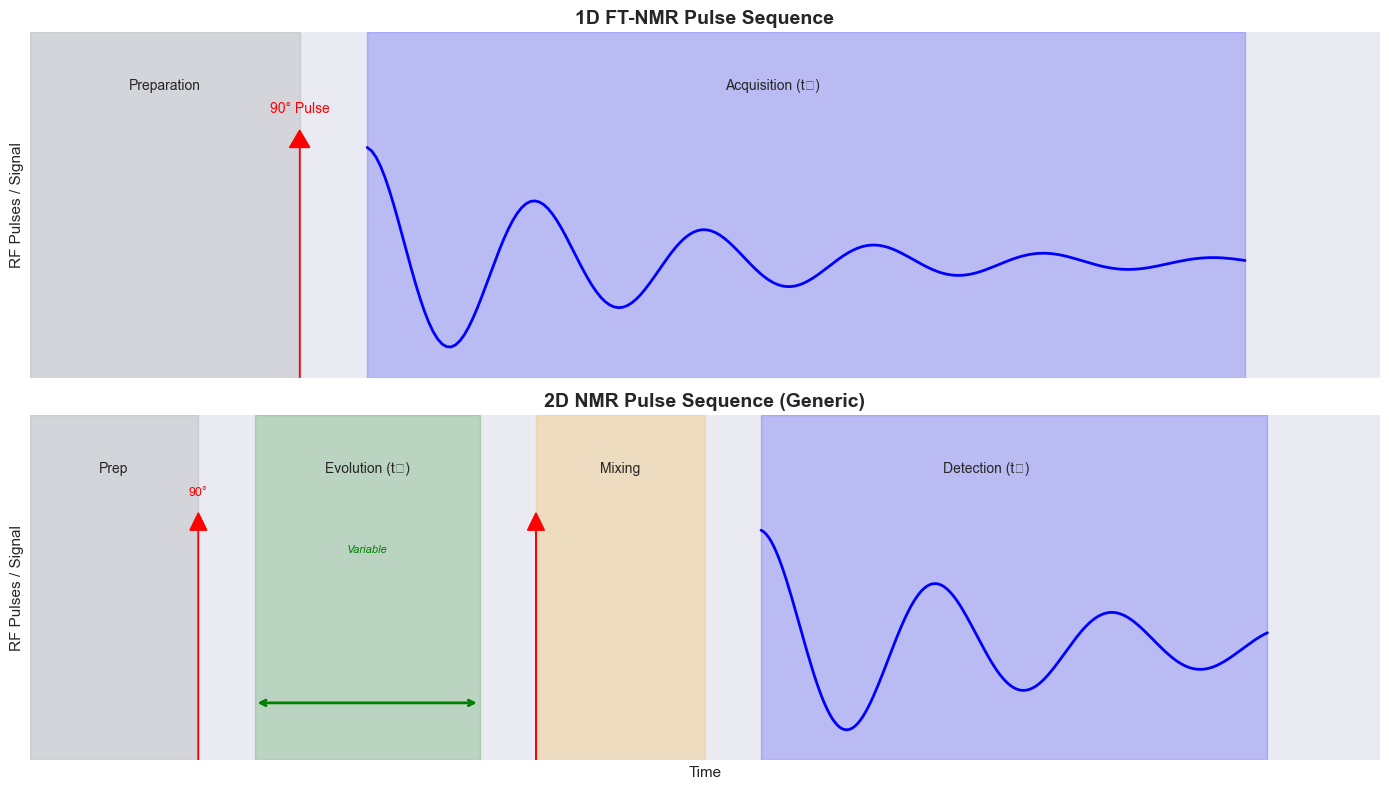

Pulse sequence comparison complete!
Note: In 2D NMR, the evolution time (t₁) is incremented systematically across multiple experiments.


In [31]:
# Visualization of 1D vs 2D NMR pulse sequences

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# 1D NMR Pulse Sequence
ax1 = axes[0]
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 3)
ax1.set_title('1D FT-NMR Pulse Sequence', fontsize=14, fontweight='bold')
ax1.set_ylabel('RF Pulses / Signal', fontsize=11)

# Preparation
ax1.axvspan(0, 2, alpha=0.2, color='gray', label='Preparation')
ax1.text(1, 2.5, 'Preparation', ha='center', fontsize=10)

# 90° Pulse
ax1.arrow(2, 0, 0, 2, head_width=0.15, head_length=0.15, fc='red', ec='red')
ax1.text(2, 2.3, '90° Pulse', ha='center', fontsize=10, color='red')

# Acquisition
ax1.axvspan(2.5, 9, alpha=0.2, color='blue')
t_acq = np.linspace(2.5, 9, 200)
fid_signal = np.exp(-0.5 * (t_acq - 2.5)) * np.cos(5 * (t_acq - 2.5))
ax1.plot(t_acq, 1 + fid_signal, 'b-', linewidth=2, label='FID Signal')
ax1.text(5.5, 2.5, 'Acquisition (t₂)', ha='center', fontsize=10)

ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# 2D NMR Pulse Sequence
ax2 = axes[1]
ax2.set_xlim(0, 12)
ax2.set_ylim(0, 3)
ax2.set_title('2D NMR Pulse Sequence (Generic)', fontsize=14, fontweight='bold')
ax2.set_ylabel('RF Pulses / Signal', fontsize=11)
ax2.set_xlabel('Time', fontsize=11)

# Preparation
ax2.axvspan(0, 1.5, alpha=0.2, color='gray')
ax2.text(0.75, 2.5, 'Prep', ha='center', fontsize=10)

# First Pulse
ax2.arrow(1.5, 0, 0, 2, head_width=0.15, head_length=0.15, fc='red', ec='red')
ax2.text(1.5, 2.3, '90°', ha='center', fontsize=9, color='red')

# Evolution period (t1 - variable)
ax2.axvspan(2, 4, alpha=0.2, color='green')
ax2.annotate('', xy=(4, 0.5), xytext=(2, 0.5),
            arrowprops=dict(arrowstyle='<->', color='green', lw=2))
ax2.text(3, 2.5, 'Evolution (t₁)', ha='center', fontsize=10)
ax2.text(3, 1.8, 'Variable', ha='center', fontsize=8, style='italic', color='green')

# Mixing period
ax2.axvspan(4.5, 6, alpha=0.2, color='orange')
ax2.arrow(4.5, 0, 0, 2, head_width=0.15, head_length=0.15, fc='red', ec='red')
ax2.text(5.25, 2.5, 'Mixing', ha='center', fontsize=10)

# Detection period
ax2.axvspan(6.5, 11, alpha=0.2, color='blue')
t_det = np.linspace(6.5, 11, 200)
fid_2d = np.exp(-0.4 * (t_det - 6.5)) * np.cos(4 * (t_det - 6.5))
ax2.plot(t_det, 1 + fid_2d, 'b-', linewidth=2)
ax2.text(8.5, 2.5, 'Detection (t₂)', ha='center', fontsize=10)

ax2.set_xticks([])
ax2.set_yticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()

print("Pulse sequence comparison complete!")
print("Note: In 2D NMR, the evolution time (t₁) is incremented systematically across multiple experiments.")

### The Spin Hamiltonian

The behavior of nuclear spins during an NMR experiment is governed by the **spin Hamiltonian**. Understanding this quantum mechanical description is essential for interpreting 2D NMR experiments.

#### One-Spin System

For a single nucleus (ignoring long-range interactions):

$$\hat{H} = \hat{H}_0 + \hat{H}_{RF}$$

Where:
- **H₀**: Static Hamiltonian containing chemical shift and J-coupling (constant)
- **H_RF**: Radio frequency Hamiltonian induced by RF pulses (time-dependent)

#### Two-Spin Coupled System

For two coupled nuclei, the static Hamiltonian is:

$$\hat{H}_0 = -\omega_1 \hat{I}_{1z} - \omega_2 \hat{I}_{2z} + 2\pi J_{12} \hat{I}_1 \cdot \hat{I}_2$$

Where:
- **ω₁, ω₂**: Larmor frequencies of nuclei 1 and 2
- **Î₁, Î₂**: Spin angular momentum operators for nuclei 1 and 2
- **J₁₂**: Scalar coupling constant between nuclei 1 and 2 (in Hz)

#### Larmor Frequency and Chemical Shift

The Larmor frequency is related to chemical shift by:

$$\omega_i = \gamma_i B_0 (1 - \sigma_i) = \gamma_i B_0 (1 + \delta_i \times 10^{-6})$$

Where:
- **γ**: Gyromagnetic ratio of the isotope
- **B₀**: Applied magnetic field strength
- **σ**: Shielding constant
- **δ**: Chemical shift in ppm

#### Homonuclear vs. Heteronuclear Systems

- **Homonuclear**: Both nuclei are the same isotope (e.g., ¹H-¹H COSY)
  - Same γ values
  - Diagonal peaks appear in 2D spectra
  
- **Heteronuclear**: Different isotopes (e.g., ¹H-¹⁵N HSQC)
  - Different γ values
  - No diagonal peaks
  - One nucleus often has low sensitivity

## Correlation Spectroscopy (COSY)

### Overview

**COSY (COrrelation SpectroscopY)** is the most fundamental 2D NMR experiment. It's a homonuclear technique that reveals which nuclei are coupled through bonds, typically within 2-3 bond distances.

### COSY Pulse Sequence

The basic COSY experiment consists of:

```
Preparation → 90° pulse → Evolution (t₁) → 90° pulse → Detection (t₂)
```

**Sequence Breakdown:**
1. **First 90° pulse**: Creates transverse magnetization
2. **Evolution period (t₁)**: Magnetization evolves under chemical shift and J-coupling
3. **Second 90° pulse**: Mixing pulse that transfers coherence between coupled spins
4. **Detection (t₂)**: FID is acquired while magnetization oscillates

### What COSY Reveals

- **Scalar coupling (J-coupling)**: Through-bond interactions
- **Connectivity**: Which nuclei are connected within 2-3 bonds
- **Spin systems**: Groups of coupled nuclei
- **Multiplicity**: Splitting patterns from coupling

### Applications

- Structure elucidation of organic molecules
- Identification of functional groups
- Assignment of NMR signals
- Determination of molecular connectivity
- Analysis of spin systems in complex molecules

### Limitations

- Only shows through-bond coupling (not spatial proximity)
- Limited to 2-3 bond connectivity
- For proteins, through-bond coupling alone is insufficient
- Can have overlapping peaks in crowded spectra

C:\Users\Windows User\AppData\Local\Temp\ipykernel_10644\1618680937.py:59: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Windows User\AppData\Local\Temp\ipykernel_10644\1618680937.py:59: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()


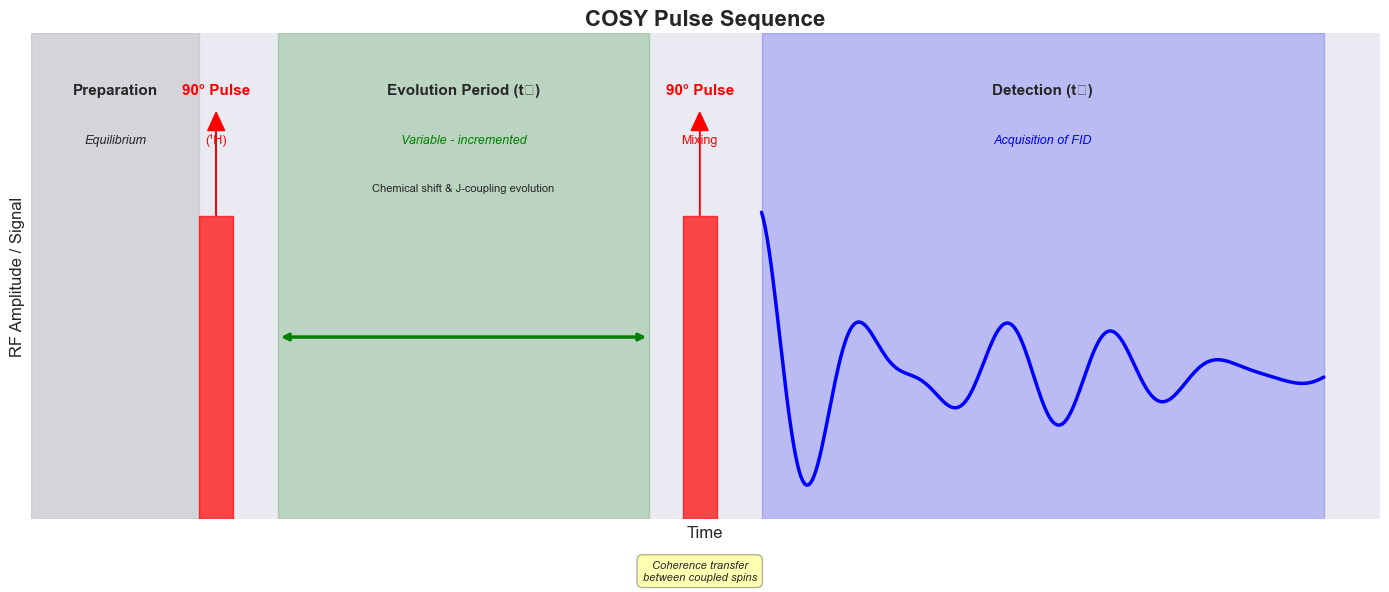

COSY Pulse Sequence:
1. Initial 90° pulse creates transverse magnetization
2. t₁ period: magnetization evolves (incremented)
3. Second 90° pulse: mixing and coherence transfer
4. t₂ period: signal detection

Result: 2D spectrum showing J-coupled nuclei


In [32]:
# COSY Pulse Sequence Visualization

fig, ax = plt.subplots(figsize=(14, 6))

ax.set_xlim(0, 12)
ax.set_ylim(0, 4)
ax.set_title('COSY Pulse Sequence', fontsize=16, fontweight='bold')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('RF Amplitude / Signal', fontsize=12)

# Preparation
ax.axvspan(0, 1.5, alpha=0.2, color='gray')
ax.text(0.75, 3.5, 'Preparation', ha='center', fontsize=11, fontweight='bold')
ax.text(0.75, 3.1, 'Equilibrium', ha='center', fontsize=9, style='italic')

# First 90° Pulse
ax.add_patch(plt.Rectangle((1.5, 0), 0.3, 2.5, color='red', alpha=0.7))
ax.arrow(1.65, 2.5, 0, 0.7, head_width=0.15, head_length=0.15, fc='red', ec='red')
ax.text(1.65, 3.5, '90° Pulse', ha='center', fontsize=11, fontweight='bold', color='red')
ax.text(1.65, 3.1, '(¹H)', ha='center', fontsize=9, color='red')

# Evolution period (t1)
ax.axvspan(2.2, 5.5, alpha=0.2, color='green')
ax.annotate('', xy=(5.5, 1.5), xytext=(2.2, 1.5),
            arrowprops=dict(arrowstyle='<->', color='green', lw=2.5))
ax.text(3.85, 3.5, 'Evolution Period (t₁)', ha='center', fontsize=11, fontweight='bold')
ax.text(3.85, 3.1, 'Variable - incremented', ha='center', fontsize=9, style='italic', color='green')
ax.text(3.85, 2.7, 'Chemical shift & J-coupling evolution', ha='center', fontsize=8)

# Second 90° Pulse (Mixing)
ax.add_patch(plt.Rectangle((5.8, 0), 0.3, 2.5, color='red', alpha=0.7))
ax.arrow(5.95, 2.5, 0, 0.7, head_width=0.15, head_length=0.15, fc='red', ec='red')
ax.text(5.95, 3.5, '90° Pulse', ha='center', fontsize=11, fontweight='bold', color='red')
ax.text(5.95, 3.1, 'Mixing', ha='center', fontsize=9, color='red')

# Detection period
ax.axvspan(6.5, 11.5, alpha=0.2, color='blue')
t_acq = np.linspace(6.5, 11.5, 300)
# Simulate FID with multiple frequency components
fid1 = 0.8 * np.exp(-0.4 * (t_acq - 6.5)) * np.cos(6 * (t_acq - 6.5))
fid2 = 0.6 * np.exp(-0.5 * (t_acq - 6.5)) * np.cos(8 * (t_acq - 6.5) + 0.5)
fid_total = fid1 + fid2
ax.plot(t_acq, 1.2 + fid_total, 'b-', linewidth=2.5, label='FID Signal')
ax.text(9, 3.5, 'Detection (t₂)', ha='center', fontsize=11, fontweight='bold')
ax.text(9, 3.1, 'Acquisition of FID', ha='center', fontsize=9, style='italic', color='blue')

# Add annotations
ax.annotate('Coherence transfer\nbetween coupled spins', xy=(5.95, 0.5), xytext=(5.95, -0.5),
            ha='center', fontsize=8, style='italic',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))

ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))

plt.tight_layout()
plt.show()

print("COSY Pulse Sequence:")
print("=" * 50)
print("1. Initial 90° pulse creates transverse magnetization")
print("2. t₁ period: magnetization evolves (incremented)")
print("3. Second 90° pulse: mixing and coherence transfer")
print("4. t₂ period: signal detection")
print("\nResult: 2D spectrum showing J-coupled nuclei")

C:\Users\Windows User\AppData\Local\Temp\ipykernel_10644\4025332605.py:87: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Windows User\AppData\Local\Temp\ipykernel_10644\4025332605.py:87: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()


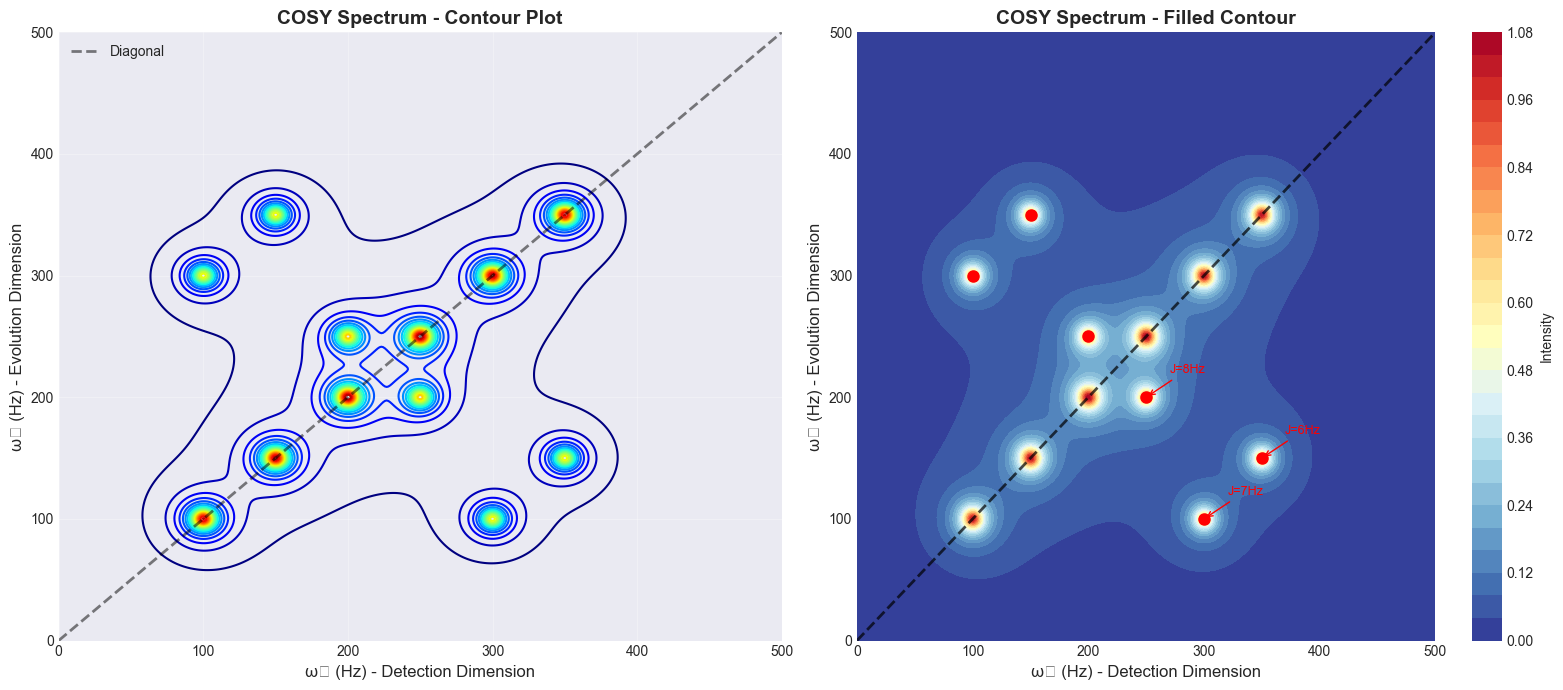

COSY Spectrum Analysis:
• Diagonal peaks: Nuclei correlating with themselves
• Cross peaks: Pairs of J-coupled nuclei
• Symmetry: COSY spectra are symmetric about diagonal
• Distance from diagonal: Related to chemical shift difference

Simulated 3 coupled spin pairs


In [33]:
# Simulate a simple COSY spectrum for a coupled two-spin system

def simulate_cosy_spectrum(freqs, couplings, linewidth=5):
    """
    Simulate a basic COSY spectrum
    
    Parameters:
    -----------
    freqs : list of tuples
        Chemical shifts of coupled pairs [(f1a, f1b), (f2a, f2b), ...]
    couplings : list
        J-coupling constants for each pair
    linewidth : float
        Linewidth for Lorentzian peaks
    """
    # Create frequency grid
    f1 = np.linspace(0, 500, 400)
    f2 = np.linspace(0, 500, 400)
    F1, F2 = np.meshgrid(f1, f2)
    
    # Initialize spectrum
    spectrum = np.zeros_like(F1)
    
    # Add diagonal peaks and cross peaks
    for (fa, fb), J in zip(freqs, couplings):
        # Diagonal peaks
        spectrum += lorentzian_2d(F1, F2, fa, fa, linewidth)
        spectrum += lorentzian_2d(F1, F2, fb, fb, linewidth)
        
        # Cross peaks (correlation)
        spectrum += 0.7 * lorentzian_2d(F1, F2, fa, fb, linewidth)
        spectrum += 0.7 * lorentzian_2d(F1, F2, fb, fa, linewidth)
    
    return F1, F2, spectrum

def lorentzian_2d(F1, F2, f1_center, f2_center, width):
    """2D Lorentzian peak"""
    return 1.0 / (1 + ((F1 - f1_center) / width)**2 + ((F2 - f2_center) / width)**2)

# Simulate COSY for a simple molecule (e.g., ethyl group)
# Chemical shifts: CH3 at 100 Hz, CH2 at 300 Hz, coupled with J = 7 Hz
coupled_pairs = [
    (100, 300),  # CH3-CH2 coupling
    (150, 350),  # Additional coupled pair
    (200, 250),  # Another coupled pair
]
J_values = [7, 6, 8]

F1, F2, cosy_spectrum = simulate_cosy_spectrum(coupled_pairs, J_values, linewidth=8)

# Plot COSY spectrum
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Contour plot
ax1 = axes[0]
levels = np.linspace(0.05, np.max(cosy_spectrum), 20)
contour = ax1.contour(F1, F2, cosy_spectrum, levels=levels, cmap='jet', linewidths=1.5)
ax1.set_xlabel('ω₂ (Hz) - Detection Dimension', fontsize=12)
ax1.set_ylabel('ω₁ (Hz) - Evolution Dimension', fontsize=12)
ax1.set_title('COSY Spectrum - Contour Plot', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add diagonal line
ax1.plot([0, 500], [0, 500], 'k--', linewidth=2, alpha=0.5, label='Diagonal')
ax1.legend()

# Filled contour plot
ax2 = axes[1]
contourf = ax2.contourf(F1, F2, cosy_spectrum, levels=30, cmap='RdYlBu_r')
ax2.set_xlabel('ω₂ (Hz) - Detection Dimension', fontsize=12)
ax2.set_ylabel('ω₁ (Hz) - Evolution Dimension', fontsize=12)
ax2.set_title('COSY Spectrum - Filled Contour', fontsize=14, fontweight='bold')
plt.colorbar(contourf, ax=ax2, label='Intensity')

# Add diagonal line
ax2.plot([0, 500], [0, 500], 'k--', linewidth=2, alpha=0.7)

# Annotate peaks
for (fa, fb), J in zip(coupled_pairs, J_values):
    # Cross peaks
    ax2.plot(fb, fa, 'ro', markersize=8)
    ax2.plot(fa, fb, 'ro', markersize=8)
    ax2.annotate(f'J={J}Hz', xy=(fb, fa), xytext=(fb+20, fa+20),
                fontsize=9, color='red',
                arrowprops=dict(arrowstyle='->', color='red', lw=1))

plt.tight_layout()
plt.show()

print("COSY Spectrum Analysis:")
print("=" * 50)
print("• Diagonal peaks: Nuclei correlating with themselves")
print("• Cross peaks: Pairs of J-coupled nuclei")
print("• Symmetry: COSY spectra are symmetric about diagonal")
print("• Distance from diagonal: Related to chemical shift difference")
print(f"\nSimulated {len(coupled_pairs)} coupled spin pairs")

# Load Real 2D NMR Data - Valerian Root Extract

Now we'll analyze **real experimental 2D NMR data** from a Valerian root extract (Valeriana officinalis) in CDCl₃. This dataset includes three complementary experiments:

1. **COSY (¹H-¹H)**: Homonuclear correlation showing through-bond ¹H-¹H coupling
2. **HMQC (¹H-¹³C)**: Heteronuclear correlation showing one-bond C-H connections
3. **HMBC (¹H-¹³C)**: Heteronuclear multiple-bond correlation showing long-range (2-4 bond) C-H connections

**About Valerian:**
- Medicinal plant used for sedative/anxiolytic effects
- Contains sesquiterpenes (valerenal, valeranone), valepotriates, and volatile oils
- Complex natural product mixture - ideal for demonstrating 2D NMR power

The data files are in `.asc` format (ASCII) with three columns: **Y** (F1 dimension, ppm), **X** (F2 dimension, ppm), and **Val** (intensity).

In [34]:
import pandas as pd
from pathlib import Path

def load_2d_nmr_asc(filepath):
    """
    Load 2D NMR data from .asc file format
    
    Parameters:
    -----------
    filepath : str or Path
        Path to the .asc file
    
    Returns:
    --------
    dict with keys:
        - 'f1': F1 dimension values (Y, ppm)
        - 'f2': F2 dimension values (X, ppm)
        - 'intensity': Intensity values
        - 'f1_grid': 2D meshgrid for F1
        - 'f2_grid': 2D meshgrid for F2
        - 'intensity_grid': 2D intensity matrix
        - 'name': Filename
    """
    filepath = Path(filepath)
    
    # Read the data with error handling for malformed rows
    # The .asc files have some lines with broken formatting
    data = pd.read_csv(filepath, sep=r'\s+', skiprows=1, names=['Y', 'X', 'Val'], 
                       on_bad_lines='skip', engine='python')
    
    # Convert columns to numeric, coercing errors to NaN
    data['Y'] = pd.to_numeric(data['Y'], errors='coerce')
    data['X'] = pd.to_numeric(data['X'], errors='coerce')
    data['Val'] = pd.to_numeric(data['Val'], errors='coerce')
    
    # Drop rows with any NaN values (malformed data)
    data = data.dropna()
    
    # Extract unique F1 and F2 values
    f1_unique = np.sort(data['Y'].unique())
    f2_unique = np.sort(data['X'].unique())
    
    # Determine grid dimensions
    n_f1 = len(f1_unique)
    n_f2 = len(f2_unique)
    
    print(f"Loaded: {filepath.name}")
    print(f"  Data points: {len(data)}")
    print(f"  F1 dimension: {n_f1} points ({f1_unique.min():.2f} to {f1_unique.max():.2f} ppm)")
    print(f"  F2 dimension: {n_f2} points ({f2_unique.min():.2f} to {f2_unique.max():.2f} ppm)")
    
    # Reshape data into 2D grid
    # Create meshgrid for plotting
    intensity_grid = np.zeros((n_f1, n_f2))
    
    # Fill the grid with intensity values
    for _, row in data.iterrows():
        i = np.where(f1_unique == row['Y'])[0][0]
        j = np.where(f2_unique == row['X'])[0][0]
        intensity_grid[i, j] = row['Val']
    
    # Create meshgrids for plotting
    f2_grid, f1_grid = np.meshgrid(f2_unique, f1_unique)
    
    return {
        'f1': f1_unique,
        'f2': f2_unique,
        'intensity': data['Val'].values,
        'f1_grid': f1_grid,
        'f2_grid': f2_grid,
        'intensity_grid': intensity_grid,
        'name': filepath.stem,
        'raw_data': data
    }

# Load all three 2D NMR datasets
data_dir = Path("data/2d_nmr_data")

print("Loading Valerian 2D NMR Datasets")
print("=" * 70)

cosy_data = load_2d_nmr_asc(data_dir / "ValerianCOSY_CDCl3.asc")
print()

hmqc_data = load_2d_nmr_asc(data_dir / "ValerianHMQC_CDCl3.asc")
print()

hmbc_data = load_2d_nmr_asc(data_dir / "ValerianHMBC_CDCl3_ASC.asc")
print()

print("✓ All datasets loaded successfully!")

Loading Valerian 2D NMR Datasets
Loaded: ValerianCOSY_CDCl3.asc
  Data points: 1048576
  F1 dimension: 1024 points (0.24 to 10.04 ppm)
  F2 dimension: 1024 points (0.24 to 10.04 ppm)
Loaded: ValerianCOSY_CDCl3.asc
  Data points: 1048576
  F1 dimension: 1024 points (0.24 to 10.04 ppm)
  F2 dimension: 1024 points (0.24 to 10.04 ppm)


Loaded: ValerianHMQC_CDCl3.asc
  Data points: 419328
  F1 dimension: 512 points (6.15 to 202.67 ppm)
  F2 dimension: 819 points (0.25 to 10.04 ppm)
Loaded: ValerianHMQC_CDCl3.asc
  Data points: 419328
  F1 dimension: 512 points (6.15 to 202.67 ppm)
  F2 dimension: 819 points (0.25 to 10.04 ppm)


Loaded: ValerianHMBC_CDCl3_ASC.asc
  Data points: 838656
  F1 dimension: 512 points (6.15 to 202.67 ppm)
  F2 dimension: 1638 points (0.24 to 10.04 ppm)
Loaded: ValerianHMBC_CDCl3_ASC.asc
  Data points: 838656
  F1 dimension: 512 points (6.15 to 202.67 ppm)
  F2 dimension: 1638 points (0.24 to 10.04 ppm)

✓ All datasets loaded successfully!

✓ All datasets loaded s

# COSY Spectrum Analysis - Valerian Root

**COSY (COrrelation SpectroscopY)** reveals ¹H-¹H coupling relationships through bonds. 

**What to look for:**
- **Diagonal peaks**: Each proton correlating with itself (1D ¹H spectrum along diagonal)
- **Cross peaks**: Pairs of protons coupled through 2-3 bonds (²J, ³J coupling)
- **Symmetry**: COSY is symmetric about the diagonal (if peak at (δ1, δ2), also at (δ2, δ1))
- **Multiplet patterns**: Fine structure in cross peaks reveals J-coupling values

**For Valerian extract:**
- Complex mixture of sesquiterpenes and other metabolites
- Multiple overlapping spin systems
- Cross peaks help trace connectivity through the molecular framework

C:\Users\Windows User\AppData\Local\Temp\ipykernel_10644\1870562553.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


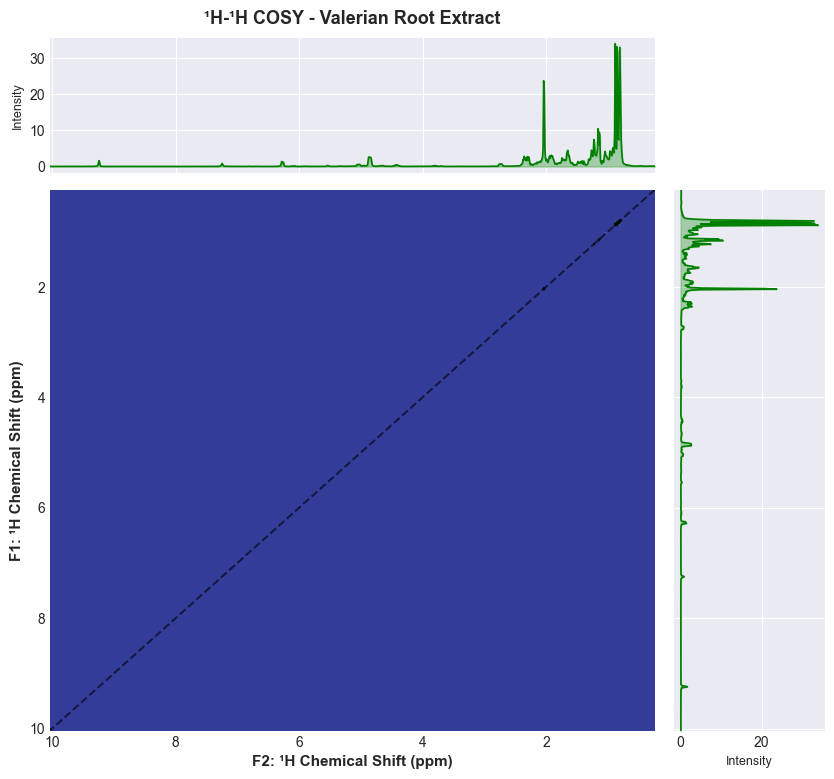

COSY Spectrum Analysis - Valerian Root
F1 range: 0.24 to 10.04 ppm
F2 range: 0.24 to 10.04 ppm
Max intensity: 1.45e+01

Spectrum Features:
  • Diagonal: All ¹H resonances (equivalent to 1D ¹H spectrum)
  • Cross peaks: ¹H-¹H correlations through J-coupling (2-3 bonds)
  • Symmetric: Cross peak at (δA, δB) mirrored at (δB, δA)

Interpretation Tips:
  • Follow cross peaks to trace spin systems
  • Aromatic region (6-8 ppm): Look for ortho/meta coupling patterns
  • Aliphatic region (0-4 ppm): CH₂-CH₂ and CH₃-CH₂ correlations
  • Complex natural product → multiple overlapping spin systems


In [35]:
# Plot COSY spectrum from real Valerian data with projections

# Create figure with GridSpec for projections
fig = plt.figure(figsize=(10, 9))
gs = fig.add_gridspec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                      hspace=0.05, wspace=0.05)

# Main 2D plot
ax_main = fig.add_subplot(gs[1, 0])

# Set appropriate contour levels
max_intensity = cosy_data['intensity_grid'].max()
levels = np.linspace(max_intensity * 0.05, max_intensity * 0.8, 25)

# Plot contours
contourf = ax_main.contourf(cosy_data['f2_grid'], cosy_data['f1_grid'], 
                            cosy_data['intensity_grid'], 
                            levels=40, cmap='RdYlBu_r')
ax_main.contour(cosy_data['f2_grid'], cosy_data['f1_grid'], 
               cosy_data['intensity_grid'], 
               levels=levels, colors='black', linewidths=0.8, alpha=0.4)

# Add diagonal line
f_min = min(cosy_data['f2'].min(), cosy_data['f1'].min())
f_max = max(cosy_data['f2'].max(), cosy_data['f1'].max())
ax_main.plot([f_min, f_max], [f_min, f_max], 'k--', linewidth=1.5, alpha=0.6)

ax_main.set_xlabel('F2: ¹H Chemical Shift (ppm)', fontsize=11, fontweight='bold')
ax_main.set_ylabel('F1: ¹H Chemical Shift (ppm)', fontsize=11, fontweight='bold')
ax_main.invert_xaxis()
ax_main.invert_yaxis()

# Top projection (F2 dimension)
ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)
f2_projection = np.sum(cosy_data['intensity_grid'], axis=0)
ax_top.plot(cosy_data['f2'], f2_projection, 'g-', linewidth=1.2)
ax_top.fill_between(cosy_data['f2'], f2_projection, alpha=0.3, color='green')
ax_top.set_ylabel('Intensity', fontsize=9)
ax_top.tick_params(labelbottom=False)
ax_top.set_title('¹H-¹H COSY - Valerian Root Extract', fontsize=13, fontweight='bold', pad=10)

# Right projection (F1 dimension)
ax_right = fig.add_subplot(gs[1, 1], sharey=ax_main)
f1_projection = np.sum(cosy_data['intensity_grid'], axis=1)
ax_right.plot(f1_projection, cosy_data['f1'], 'g-', linewidth=1.2)
ax_right.fill_betweenx(cosy_data['f1'], f1_projection, alpha=0.3, color='green')
ax_right.set_xlabel('Intensity', fontsize=9)
ax_right.tick_params(labelleft=False)

plt.tight_layout()
plt.show()

# Print analysis
print("COSY Spectrum Analysis - Valerian Root")
print("=" * 70)
print(f"F1 range: {cosy_data['f1'].min():.2f} to {cosy_data['f1'].max():.2f} ppm")
print(f"F2 range: {cosy_data['f2'].min():.2f} to {cosy_data['f2'].max():.2f} ppm")
print(f"Max intensity: {max_intensity:.2e}")
print("\nSpectrum Features:")
print("  • Diagonal: All ¹H resonances (equivalent to 1D ¹H spectrum)")
print("  • Cross peaks: ¹H-¹H correlations through J-coupling (2-3 bonds)")
print("  • Symmetric: Cross peak at (δA, δB) mirrored at (δB, δA)")
print("\nInterpretation Tips:")
print("  • Follow cross peaks to trace spin systems")
print("  • Aromatic region (6-8 ppm): Look for ortho/meta coupling patterns")
print("  • Aliphatic region (0-4 ppm): CH₂-CH₂ and CH₃-CH₂ correlations")
print("  • Complex natural product → multiple overlapping spin systems")

# HMQC Spectrum Analysis - Valerian Root

**HMQC (Heteronuclear Multiple Quantum Coherence)** is the predecessor to HSQC and shows **one-bond ¹H-¹³C correlations**.

**Key Characteristics:**
- **F1 dimension**: ¹³C chemical shifts (typically 0-220 ppm)
- **F2 dimension**: ¹H chemical shifts (typically 0-12 ppm)
- **Cross peaks**: Each peak represents a C-H bond (¹JCH coupling, ~125-250 Hz)
- **No diagonal**: Different nuclei (¹H vs ¹³C), so no autocorrelation diagonal

**Comparison: HMQC vs HSQC**
- HMQC: Uses multiple-quantum coherence, slightly older technique
- HSQC: Uses single-quantum coherence, better sensitivity and resolution
- Both show **direct C-H bonds** (one-bond correlations)

**For structure elucidation:**
- Identifies which hydrogens are attached to which carbons
- Essential for assigning carbon framework
- Complements HMBC (which shows long-range C-H correlations)

C:\Users\Windows User\AppData\Local\Temp\ipykernel_10644\1989906293.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\Windows User\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8323 (\N{SUBSCRIPT THREE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Windows User\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


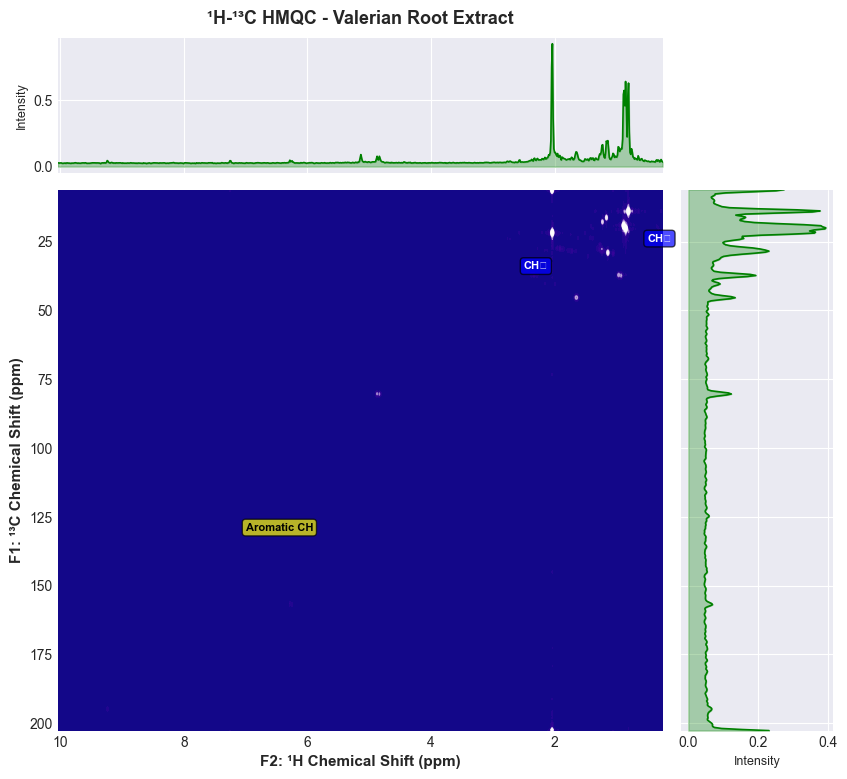

HMQC Spectrum Analysis - Valerian Root
F1 (¹³C) range: 6.15 to 202.67 ppm
F2 (¹H) range: 0.25 to 10.04 ppm
Max intensity: 7.17e-02

Spectrum Regions:
  • 0-50 ppm (¹³C): Aliphatic carbons (CH₃, CH₂, CH)
  • 50-100 ppm (¹³C): Carbons bonded to O or N (ethers, alcohols)
  • 100-160 ppm (¹³C): Aromatic and alkene carbons (C=C)
  • 160-220 ppm (¹³C): Carbonyl carbons (typically no direct C-H)

Key Information:
  • Each cross peak = one direct C-H bond (¹JCH ~ 125-250 Hz)
  • Peak position reveals both C and H chemical environments
  • Essential for carbon skeleton assignment

Structural Insights:
  • Multiple CH₂ peaks → aliphatic chains (terpenoid backbones)
  • Aromatic CH peaks → aromatic rings in sesquiterpenes
  • Correlation with COSY reveals connected proton systems


In [36]:
# Plot HMQC spectrum from real Valerian data with projections

# Create figure with GridSpec for projections
fig = plt.figure(figsize=(10, 9))
gs = fig.add_gridspec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                      hspace=0.05, wspace=0.05)

# Main 2D plot
ax_main = fig.add_subplot(gs[1, 0])

max_intensity_hmqc = hmqc_data['intensity_grid'].max()
levels_hmqc = np.linspace(max_intensity_hmqc * 0.08, max_intensity_hmqc * 0.9, 30)

# Plot contours
contourf = ax_main.contourf(hmqc_data['f2_grid'], hmqc_data['f1_grid'], 
                            hmqc_data['intensity_grid'], 
                            levels=50, cmap='plasma')
ax_main.contour(hmqc_data['f2_grid'], hmqc_data['f1_grid'], 
               hmqc_data['intensity_grid'], 
               levels=levels_hmqc, colors='white', linewidths=0.8, alpha=0.5)

ax_main.set_xlabel('F2: ¹H Chemical Shift (ppm)', fontsize=11, fontweight='bold')
ax_main.set_ylabel('F1: ¹³C Chemical Shift (ppm)', fontsize=11, fontweight='bold')
ax_main.invert_xaxis()
ax_main.invert_yaxis()

# Annotate key regions
ax_main.text(0.5, 25, 'CH₃', fontsize=8, color='white', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='blue', alpha=0.7))
ax_main.text(2.5, 35, 'CH₂', fontsize=8, color='white', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='blue', alpha=0.7))
ax_main.text(7.0, 130, 'Aromatic CH', fontsize=8, color='black', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# Top projection (F2 - ¹H dimension)
ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)
f2_projection = np.sum(hmqc_data['intensity_grid'], axis=0)
ax_top.plot(hmqc_data['f2'], f2_projection, 'g-', linewidth=1.2)
ax_top.fill_between(hmqc_data['f2'], f2_projection, alpha=0.3, color='green')
ax_top.set_ylabel('Intensity', fontsize=9)
ax_top.tick_params(labelbottom=False)
ax_top.set_title('¹H-¹³C HMQC - Valerian Root Extract', fontsize=13, fontweight='bold', pad=10)

# Right projection (F1 - ¹³C dimension)
ax_right = fig.add_subplot(gs[1, 1], sharey=ax_main)
f1_projection = np.sum(hmqc_data['intensity_grid'], axis=1)
ax_right.plot(f1_projection, hmqc_data['f1'], 'g-', linewidth=1.2)
ax_right.fill_betweenx(hmqc_data['f1'], f1_projection, alpha=0.3, color='green')
ax_right.set_xlabel('Intensity', fontsize=9)
ax_right.tick_params(labelleft=False)

plt.tight_layout()
plt.show()

# Analysis summary
print("HMQC Spectrum Analysis - Valerian Root")
print("=" * 70)
print(f"F1 (¹³C) range: {hmqc_data['f1'].min():.2f} to {hmqc_data['f1'].max():.2f} ppm")
print(f"F2 (¹H) range: {hmqc_data['f2'].min():.2f} to {hmqc_data['f2'].max():.2f} ppm")
print(f"Max intensity: {max_intensity_hmqc:.2e}")
print("\nSpectrum Regions:")
print("  • 0-50 ppm (¹³C): Aliphatic carbons (CH₃, CH₂, CH)")
print("  • 50-100 ppm (¹³C): Carbons bonded to O or N (ethers, alcohols)")
print("  • 100-160 ppm (¹³C): Aromatic and alkene carbons (C=C)")
print("  • 160-220 ppm (¹³C): Carbonyl carbons (typically no direct C-H)")
print("\nKey Information:")
print("  • Each cross peak = one direct C-H bond (¹JCH ~ 125-250 Hz)")
print("  • Peak position reveals both C and H chemical environments")
print("  • Essential for carbon skeleton assignment")
print("\nStructural Insights:")
print("  • Multiple CH₂ peaks → aliphatic chains (terpenoid backbones)")
print("  • Aromatic CH peaks → aromatic rings in sesquiterpenes")
print("  • Correlation with COSY reveals connected proton systems")

# HMBC Spectrum Analysis - Valerian Root

**HMBC (Heteronuclear Multiple Bond Correlation)** shows **long-range ¹H-¹³C correlations** through 2, 3, or 4 bonds.

**Key Differences from HMQC:**

| Feature | HMQC | HMBC |
|---------|------|------|
| **Coupling** | ¹JCH (one-bond, ~125-250 Hz) | ²JCH, ³JCH (2-4 bonds, ~2-15 Hz) |
| **Shows** | Direct C-H bonds | Long-range C-H correlations |
| **Use** | Assign directly bonded C-H | Connect distant carbons to protons |

**Why HMBC is Essential:**
- Reveals connectivity **across** the molecule, not just adjacent atoms
- Critical for determining quaternary carbons (no direct H, invisible in HMQC)
- Establishes connections between molecular fragments
- Resolves ambiguities in structure elucidation

**For Valerian sesquiterpenes:**
- Quaternary carbons at ring junctions → no HMQC peaks
- HMBC reveals connections from these carbons to nearby H (2-3 bonds away)
- Combined with HMQC: builds complete carbon skeleton

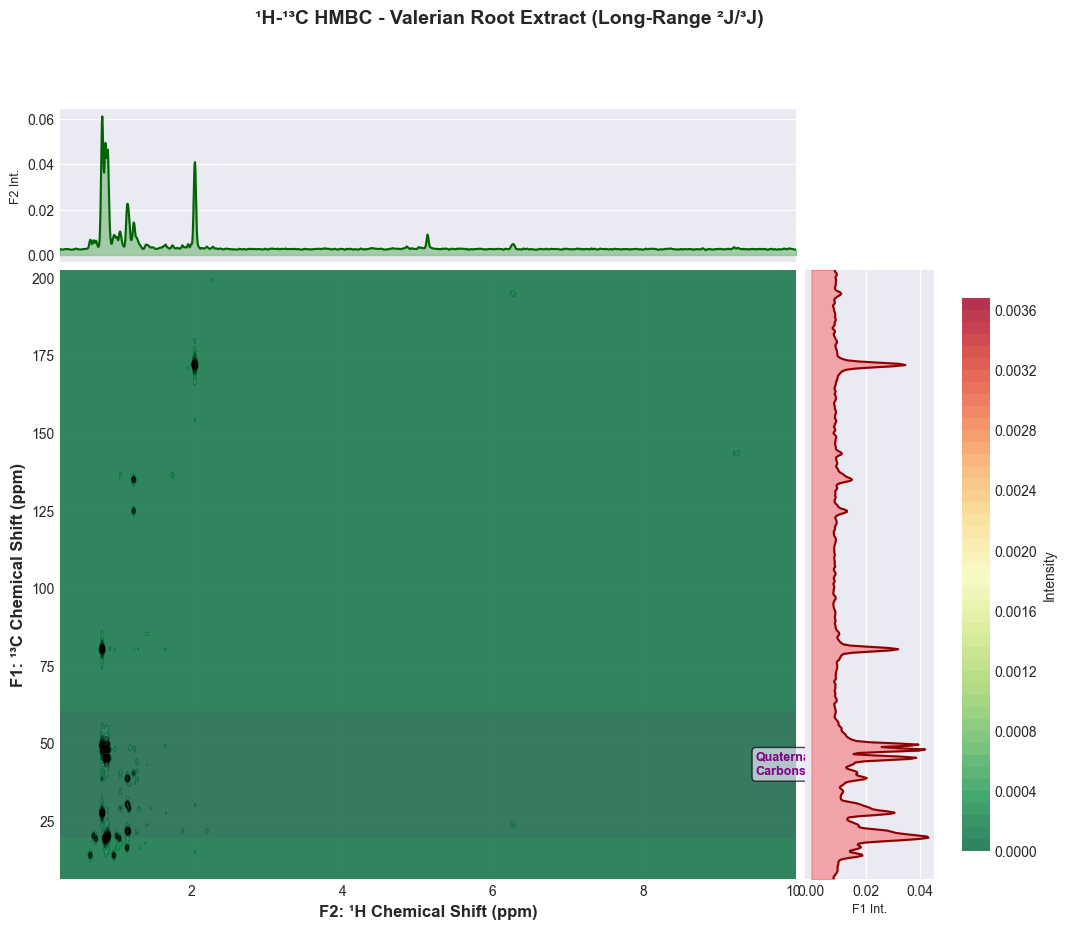

HMBC Spectrum Analysis - Valerian Root
F1 (¹³C) range: 6.15 to 202.67 ppm
F2 (¹H) range: 0.24 to 10.04 ppm
Max intensity: 3.66e-03

HMBC vs HMQC Comparison:
  HMQC: Shows direct C-H bonds (¹JCH, one bond)
  HMBC: Shows long-range C-H (²JCH, ³JCH, 2-4 bonds)

Why HMBC Matters:
  ✓ Quaternary carbons: No H attached → invisible in HMQC
  ✓ HMBC reveals these by showing nearby H correlations
  ✓ Connects molecular fragments across the structure
  ✓ Resolves structural ambiguities

Structure Elucidation Strategy:
  1. HMQC: Identify all C-H bonds directly
  2. HMBC: Connect fragments via long-range correlations
  3. COSY: Trace proton connectivity within fragments
  4. Combine all three → complete molecular structure!

For Valerian:
  • Sesquiterpene backbones have multiple quaternary carbons
  • HMBC is essential to map ring junctions and branching points
  • Long-range correlations reveal stereochemistry


In [38]:
# Plot HMBC spectrum from real Valerian data with projections

fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], 
                      hspace=0.02, wspace=0.02)

# Create axes
ax_main = fig.add_subplot(gs[1, 0])  # Main 2D plot (bottom-left)
ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)  # F2 projection (top-left)
ax_right = fig.add_subplot(gs[1, 1], sharey=ax_main)  # F1 projection (bottom-right)

# Main HMBC spectrum with enhanced visualization
max_intensity_hmbc = hmbc_data['intensity_grid'].max()
levels_hmbc = np.linspace(max_intensity_hmbc * 0.06, max_intensity_hmbc * 0.85, 35)

# Filled contours with RdYlGn_r colormap
contourf = ax_main.contourf(hmbc_data['f2_grid'], hmbc_data['f1_grid'], 
                             hmbc_data['intensity_grid'], 
                             levels=50, cmap='RdYlGn_r', alpha=0.8)
# Contour lines
ax_main.contour(hmbc_data['f2_grid'], hmbc_data['f1_grid'], 
                hmbc_data['intensity_grid'], 
                levels=levels_hmbc, colors='black', linewidths=0.8, alpha=0.5)

ax_main.set_xlabel('F2: ¹H Chemical Shift (ppm)', fontsize=12, fontweight='bold')
ax_main.set_ylabel('F1: ¹³C Chemical Shift (ppm)', fontsize=12, fontweight='bold')
ax_main.invert_xaxis()
ax_main.invert_yaxis()
ax_main.grid(True, alpha=0.3, linestyle=':')

# Highlight quaternary carbon region
ax_main.axhspan(20, 60, alpha=0.08, color='purple')
ax_main.text(9.5, 40, 'Quaternary\nCarbons', fontsize=9, color='purple', fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lavender', alpha=0.7))

# Add colorbar
cbar = plt.colorbar(contourf, ax=ax_right, label='Intensity', pad=0.15)

# F2 (¹H) projection on top
f2_projection = np.sum(hmbc_data['intensity_grid'], axis=0)
f2_axis = hmbc_data['f2_grid'][0, :] if hmbc_data['f2_grid'].ndim == 2 else hmbc_data['f2']
ax_top.plot(f2_axis, f2_projection, 'darkgreen', linewidth=1.5)
ax_top.fill_between(f2_axis, f2_projection, alpha=0.3, color='green')
ax_top.set_ylabel('F2 Int.', fontsize=9)
ax_top.tick_params(labelbottom=False)
ax_top.invert_xaxis()
ax_top.grid(True, alpha=0.2, axis='x', linestyle=':')

# F1 (¹³C) projection on right
f1_projection = np.sum(hmbc_data['intensity_grid'], axis=1)
f1_axis = hmbc_data['f1_grid'][:, 0] if hmbc_data['f1_grid'].ndim == 2 else hmbc_data['f1']
ax_right.plot(f1_projection, f1_axis, 'darkred', linewidth=1.5)
ax_right.fill_betweenx(f1_axis, f1_projection, alpha=0.3, color='red')
ax_right.set_xlabel('F1 Int.', fontsize=9)
ax_right.tick_params(labelleft=False)
ax_right.invert_yaxis()
ax_right.grid(True, alpha=0.2, axis='y', linestyle=':')

# Title
fig.suptitle('¹H-¹³C HMBC - Valerian Root Extract (Long-Range ²J/³J)', 
             fontsize=14, fontweight='bold', y=0.98)

plt.show()

# Analysis
print("HMBC Spectrum Analysis - Valerian Root")
print("=" * 70)
print(f"F1 (¹³C) range: {hmbc_data['f1'].min():.2f} to {hmbc_data['f1'].max():.2f} ppm")
print(f"F2 (¹H) range: {hmbc_data['f2'].min():.2f} to {hmbc_data['f2'].max():.2f} ppm")
print(f"Max intensity: {max_intensity_hmbc:.2e}")
print("\nHMBC vs HMQC Comparison:")
print("  HMQC: Shows direct C-H bonds (¹JCH, one bond)")
print("  HMBC: Shows long-range C-H (²JCH, ³JCH, 2-4 bonds)")
print("\nWhy HMBC Matters:")
print("  ✓ Quaternary carbons: No H attached → invisible in HMQC")
print("  ✓ HMBC reveals these by showing nearby H correlations")
print("  ✓ Connects molecular fragments across the structure")
print("  ✓ Resolves structural ambiguities")
print("\nStructure Elucidation Strategy:")
print("  1. HMQC: Identify all C-H bonds directly")
print("  2. HMBC: Connect fragments via long-range correlations")
print("  3. COSY: Trace proton connectivity within fragments")
print("  4. Combine all three → complete molecular structure!")
print("\nFor Valerian:")
print("  • Sesquiterpene backbones have multiple quaternary carbons")
print("  • HMBC is essential to map ring junctions and branching points")
print("  • Long-range correlations reveal stereochemistry")

# Comparative Analysis: COSY, HMQC, and HMBC

Now we'll visualize all three 2D NMR experiments side-by-side to understand how they **complement each other** in structure elucidation.

**Synergistic Approach:**
1. **COSY** (¹H-¹H): Traces proton connectivity through spin systems
2. **HMQC** (¹H-¹³C, direct): Maps which H is attached to which C
3. **HMBC** (¹H-¹³C, long-range): Connects distant fragments, reveals quaternary carbons

**Together they provide:**
- Complete connectivity map of the molecule
- Carbon skeleton assignment
- Proton spin system identification
- Quaternary carbon positions
- Stereochemical information

C:\Users\Windows User\AppData\Local\Temp\ipykernel_10644\105411002.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


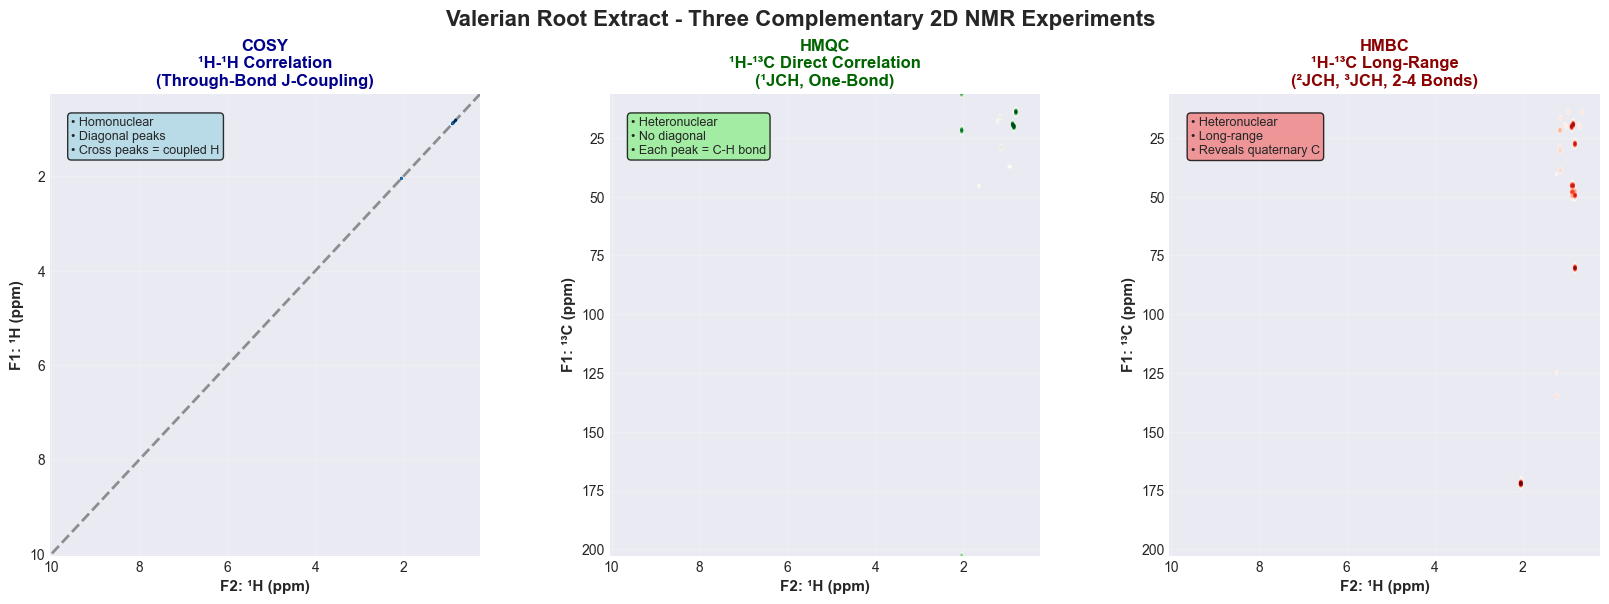


COMPARATIVE ANALYSIS: COSY, HMQC, and HMBC

Feature         COSY                      HMQC                      HMBC                     
------------------------------------------------------------------------------------------
Nuclei          ¹H-¹H                     ¹H-¹³C                    ¹H-¹³C                   
Type            Homonuclear               Heteronuclear             Heteronuclear            
Coupling        J (2-3 bonds)             ¹JCH (1 bond)             ²JCH, ³JCH (2-4 bonds)   
Diagonal        Yes                       No                        No                       
Information     H-H connectivity          Direct C-H bonds          Long-range C-H           
Best for        Spin systems              C skeleton                Quaternary C             
------------------------------------------------------------------------------------------

📊 DATA SUMMARY
------------------------------------------------------------------------------------------
COSY:  1

In [39]:
# Side-by-side comparison of all three 2D NMR experiments

fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(1, 3, hspace=0.3, wspace=0.3)

# COSY plot
ax1 = fig.add_subplot(gs[0, 0])
levels_cosy_comp = np.linspace(cosy_data['intensity_grid'].max() * 0.1, 
                               cosy_data['intensity_grid'].max() * 0.8, 20)
contour1 = ax1.contour(cosy_data['f2_grid'], cosy_data['f1_grid'], 
                       cosy_data['intensity_grid'], 
                       levels=levels_cosy_comp, cmap='Blues', linewidths=1.5)
ax1.plot([cosy_data['f2'].min(), cosy_data['f2'].max()], 
         [cosy_data['f1'].min(), cosy_data['f1'].max()], 
         'k--', linewidth=2, alpha=0.4)
ax1.set_xlabel('F2: ¹H (ppm)', fontsize=11, fontweight='bold')
ax1.set_ylabel('F1: ¹H (ppm)', fontsize=11, fontweight='bold')
ax1.set_title('COSY\n¹H-¹H Correlation\n(Through-Bond J-Coupling)', 
              fontsize=12, fontweight='bold', color='darkblue')
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.grid(True, alpha=0.2)
ax1.text(0.05, 0.95, '• Homonuclear\n• Diagonal peaks\n• Cross peaks = coupled H', 
         transform=ax1.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# HMQC plot
ax2 = fig.add_subplot(gs[0, 1])
levels_hmqc_comp = np.linspace(hmqc_data['intensity_grid'].max() * 0.1, 
                               hmqc_data['intensity_grid'].max() * 0.85, 20)
contour2 = ax2.contour(hmqc_data['f2_grid'], hmqc_data['f1_grid'], 
                       hmqc_data['intensity_grid'], 
                       levels=levels_hmqc_comp, cmap='Greens', linewidths=1.5)
ax2.set_xlabel('F2: ¹H (ppm)', fontsize=11, fontweight='bold')
ax2.set_ylabel('F1: ¹³C (ppm)', fontsize=11, fontweight='bold')
ax2.set_title('HMQC\n¹H-¹³C Direct Correlation\n(¹JCH, One-Bond)', 
              fontsize=12, fontweight='bold', color='darkgreen')
ax2.invert_xaxis()
ax2.invert_yaxis()
ax2.grid(True, alpha=0.2)
ax2.text(0.05, 0.95, '• Heteronuclear\n• No diagonal\n• Each peak = C-H bond', 
         transform=ax2.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# HMBC plot
ax3 = fig.add_subplot(gs[0, 2])
levels_hmbc_comp = np.linspace(hmbc_data['intensity_grid'].max() * 0.08, 
                               hmbc_data['intensity_grid'].max() * 0.85, 20)
contour3 = ax3.contour(hmbc_data['f2_grid'], hmbc_data['f1_grid'], 
                       hmbc_data['intensity_grid'], 
                       levels=levels_hmbc_comp, cmap='Reds', linewidths=1.5)
ax3.set_xlabel('F2: ¹H (ppm)', fontsize=11, fontweight='bold')
ax3.set_ylabel('F1: ¹³C (ppm)', fontsize=11, fontweight='bold')
ax3.set_title('HMBC\n¹H-¹³C Long-Range\n(²JCH, ³JCH, 2-4 Bonds)', 
              fontsize=12, fontweight='bold', color='darkred')
ax3.invert_xaxis()
ax3.invert_yaxis()
ax3.grid(True, alpha=0.2)
ax3.text(0.05, 0.95, '• Heteronuclear\n• Long-range\n• Reveals quaternary C', 
         transform=ax3.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

plt.suptitle('Valerian Root Extract - Three Complementary 2D NMR Experiments', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Comprehensive analysis table
print("\n" + "=" * 90)
print("COMPARATIVE ANALYSIS: COSY, HMQC, and HMBC")
print("=" * 90)
print("\n{:<15} {:<25} {:<25} {:<25}".format("Feature", "COSY", "HMQC", "HMBC"))
print("-" * 90)
print("{:<15} {:<25} {:<25} {:<25}".format("Nuclei", "¹H-¹H", "¹H-¹³C", "¹H-¹³C"))
print("{:<15} {:<25} {:<25} {:<25}".format("Type", "Homonuclear", "Heteronuclear", "Heteronuclear"))
print("{:<15} {:<25} {:<25} {:<25}".format("Coupling", "J (2-3 bonds)", "¹JCH (1 bond)", "²JCH, ³JCH (2-4 bonds)"))
print("{:<15} {:<25} {:<25} {:<25}".format("Diagonal", "Yes", "No", "No"))
print("{:<15} {:<25} {:<25} {:<25}".format("Information", "H-H connectivity", "Direct C-H bonds", "Long-range C-H"))
print("{:<15} {:<25} {:<25} {:<25}".format("Best for", "Spin systems", "C skeleton", "Quaternary C"))
print("-" * 90)

print("\n📊 DATA SUMMARY")
print("-" * 90)
print(f"COSY:  {len(cosy_data['f1'])} × {len(cosy_data['f2'])} points | "
      f"F1: {cosy_data['f1'].min():.1f}-{cosy_data['f1'].max():.1f} ppm (¹H) | "
      f"F2: {cosy_data['f2'].min():.1f}-{cosy_data['f2'].max():.1f} ppm (¹H)")
print(f"HMQC:  {len(hmqc_data['f1'])} × {len(hmqc_data['f2'])} points | "
      f"F1: {hmqc_data['f1'].min():.1f}-{hmqc_data['f1'].max():.1f} ppm (¹³C) | "
      f"F2: {hmqc_data['f2'].min():.1f}-{hmqc_data['f2'].max():.1f} ppm (¹H)")
print(f"HMBC:  {len(hmbc_data['f1'])} × {len(hmbc_data['f2'])} points | "
      f"F1: {hmbc_data['f1'].min():.1f}-{hmbc_data['f1'].max():.1f} ppm (¹³C) | "
      f"F2: {hmbc_data['f2'].min():.1f}-{hmbc_data['f2'].max():.1f} ppm (¹H)")

print("\n🔬 STRUCTURE ELUCIDATION WORKFLOW")
print("-" * 90)
print("Step 1: HMQC → Identify all C-H bonds (carbon skeleton with attached H)")
print("Step 2: COSY → Trace H-H connectivity (identify spin systems)")
print("Step 3: HMBC → Connect fragments via long-range correlations")
print("         └─→ Reveals quaternary carbons (no H attached)")
print("         └─→ Establishes C-C connectivity across molecule")
print("Step 4: Integrate all data → Deduce complete molecular structure")
print("\n✨ For Valerian: These three experiments are sufficient to:")
print("   • Map the entire carbon framework")
print("   • Identify functional groups")
print("   • Determine connectivity of sesquiterpene components")
print("   • Distinguish between structural isomers")
print("=" * 90)

# Practical Example: Using 2D NMR Data for Structure Elucidation

Let's demonstrate how to use the three experiments together to deduce structural features of the Valerian extract.

## Workflow Example: Identifying a Sesquiterpene Fragment

**Given:** We observe the following cross peaks in our spectra:

### Step-by-Step Analysis:
1. **Start with HMQC**: Find a carbon at ~40 ppm with H at ~2.5 ppm
   - Conclusion: CH₂ or CH group in aliphatic region

2. **Check COSY**: Look for cross peaks from H at 2.5 ppm
   - Find correlation to H at ~1.8 ppm and ~5.2 ppm
   - Conclusion: This proton is coupled to nearby protons (within 2-3 bonds)

3. **Examine HMBC**: Look for long-range correlations from H at 2.5 ppm
   - Find correlations to carbons at ~25 ppm (quaternary) and ~125 ppm (alkene)
   - Conclusion: This CH₂ is 2-3 bonds from a quaternary carbon and an alkene

4. **Integrate the information**:
   - Fragment identified: -CH₂-C(quaternary)-C=C-
   - Typical of terpenoid backbone!

This iterative process, repeated for all peaks, builds the complete molecular structure.

C:\Users\Windows User\AppData\Local\Temp\ipykernel_10644\2976882556.py:99: UserWarning: Glyph 8323 (\N{SUBSCRIPT THREE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Windows User\AppData\Local\Temp\ipykernel_10644\2976882556.py:99: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Windows User\AppData\Local\Temp\ipykernel_10644\2976882556.py:99: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Windows User\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Windows User\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


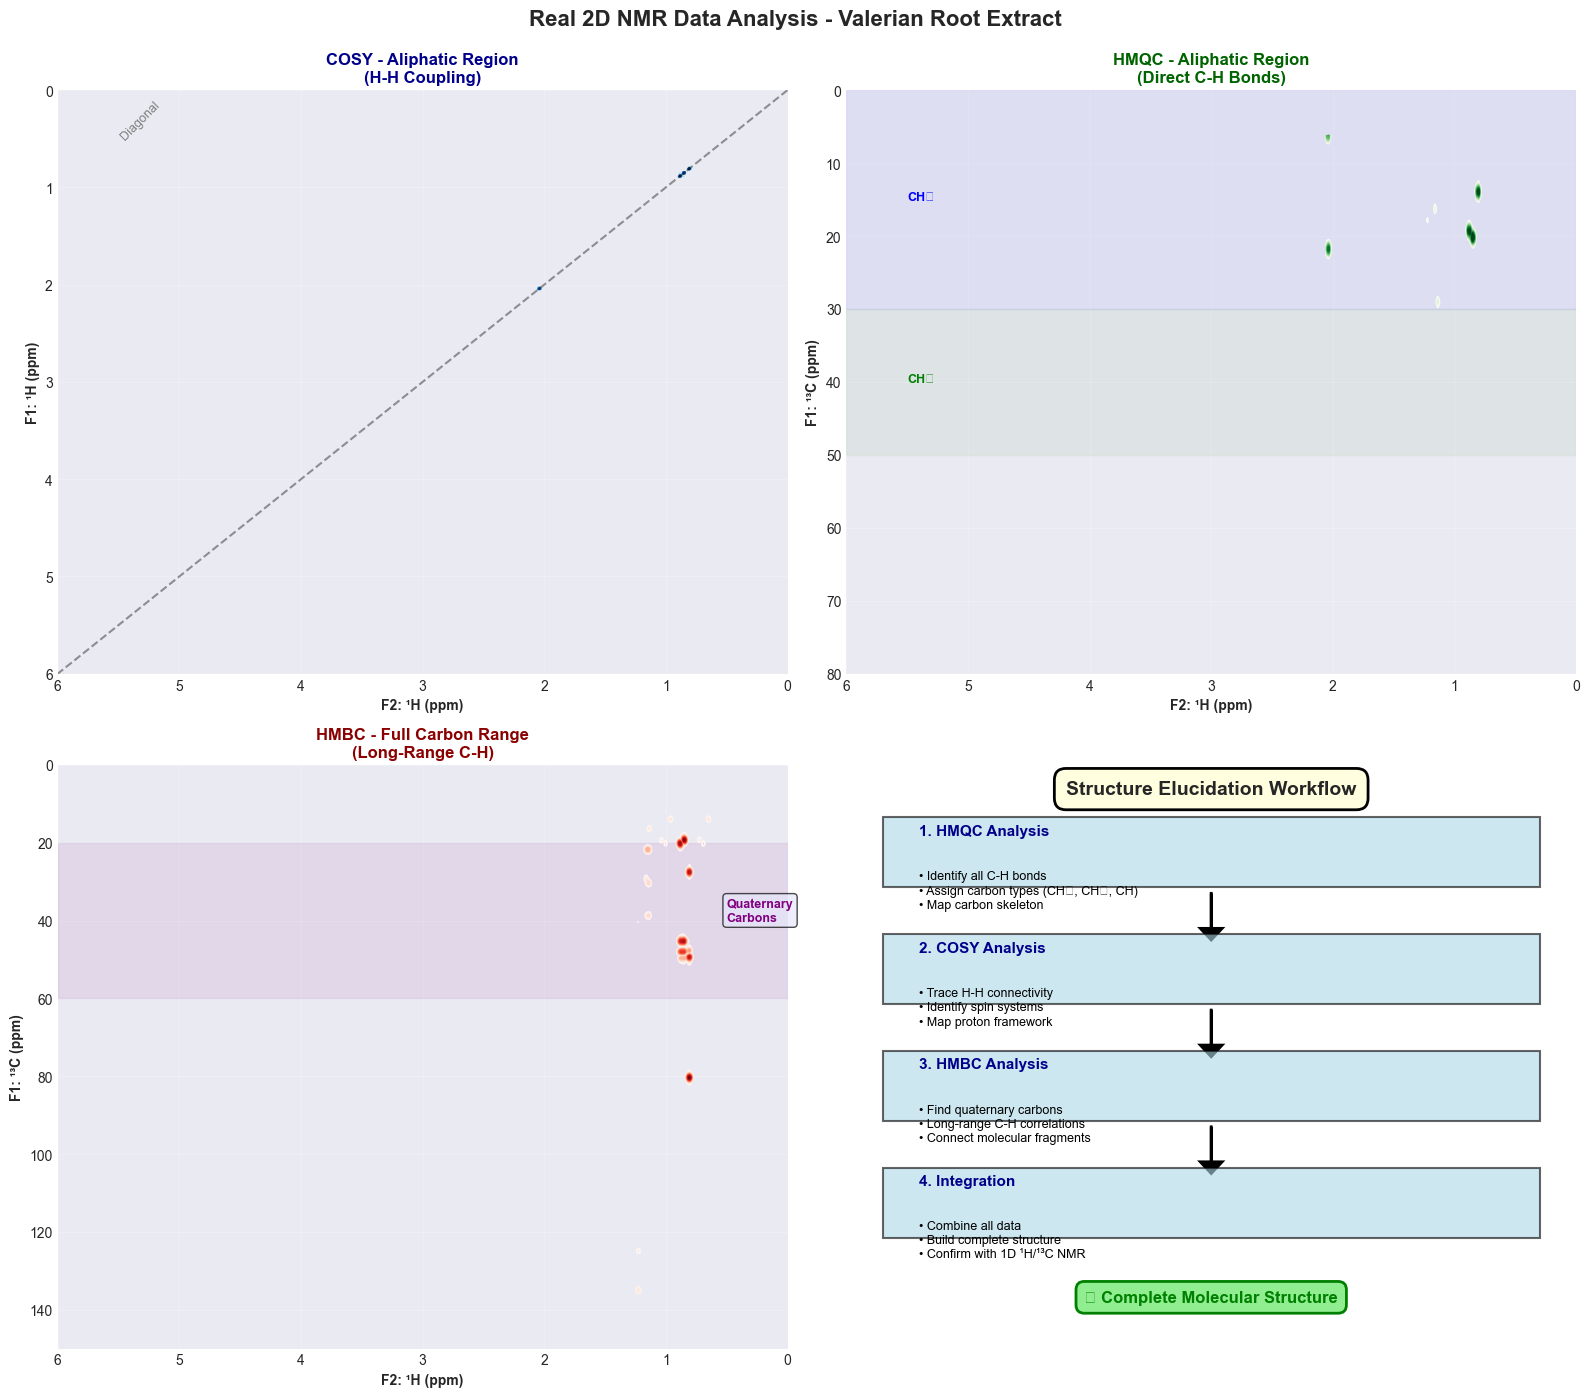


COMPREHENSIVE 2D NMR ANALYSIS COMPLETE

✓ Successfully loaded and analyzed three complementary 2D NMR datasets:
  • COSY: ¹H-¹H correlations (homonuclear)
  • HMQC: ¹H-¹³C direct correlations (heteronuclear, one-bond)
  • HMBC: ¹H-¹³C long-range correlations (heteronuclear, 2-4 bonds)

📊 Data from: Valerian root extract (Valeriana officinalis) in CDCl₃

🧪 These experiments together enable:
  1. Complete structural characterization of complex natural products
  2. Identification of quaternary carbons (no attached H)
  3. Elucidation of molecular connectivity and stereochemistry
  4. Differentiation between structural isomers

💡 Key Insight:
  2D NMR is essential for complex molecules where 1D NMR alone
  would show overlapping, ambiguous peaks. By spreading signals
  across two dimensions and revealing correlations, we can solve
  structures that would otherwise be intractable.



In [40]:
# Visualize the structure elucidation workflow with real data insights

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Top left: COSY zoomed to show a specific correlation
ax1 = axes[0, 0]
# Use full grid and set display limits (simpler and more robust)
levels_zoom = np.linspace(cosy_data['intensity_grid'].max() * 0.15, 
                          cosy_data['intensity_grid'].max() * 0.7, 15)
ax1.contour(cosy_data['f2_grid'], cosy_data['f1_grid'], 
            cosy_data['intensity_grid'], 
            levels=levels_zoom, cmap='Blues', linewidths=1.3)
ax1.plot([0, 6], [0, 6], 'k--', linewidth=1.5, alpha=0.4)
# Zoom to aliphatic region (0-6 ppm)
ax1.set_xlim(6, 0)
ax1.set_ylim(6, 0)
ax1.set_xlabel('F2: ¹H (ppm)', fontweight='bold')
ax1.set_ylabel('F1: ¹H (ppm)', fontweight='bold')
ax1.set_title('COSY - Aliphatic Region\n(H-H Coupling)', fontweight='bold', color='darkblue')
ax1.grid(True, alpha=0.2)
ax1.text(5.5, 0.5, 'Diagonal', fontsize=9, rotation=45, color='gray')

# Top right: HMQC zoomed
ax2 = axes[0, 1]
# Focus on aliphatic carbon region (0-80 ppm C, 0-6 ppm H)
levels_hmqc_zoom = np.linspace(hmqc_data['intensity_grid'].max() * 0.15, 
                               hmqc_data['intensity_grid'].max() * 0.8, 15)
ax2.contour(hmqc_data['f2_grid'], hmqc_data['f1_grid'], 
            hmqc_data['intensity_grid'], 
            levels=levels_hmqc_zoom, cmap='Greens', linewidths=1.3)
ax2.set_xlim(6, 0)
ax2.set_ylim(80, 0)
ax2.set_xlabel('F2: ¹H (ppm)', fontweight='bold')
ax2.set_ylabel('F1: ¹³C (ppm)', fontweight='bold')
ax2.set_title('HMQC - Aliphatic Region\n(Direct C-H Bonds)', fontweight='bold', color='darkgreen')
ax2.grid(True, alpha=0.2)
# Mark regions
ax2.axhspan(0, 30, alpha=0.05, color='blue')
ax2.text(5.5, 15, 'CH₃', fontsize=9, fontweight='bold', color='blue')
ax2.axhspan(30, 50, alpha=0.05, color='green')
ax2.text(5.5, 40, 'CH₂', fontsize=9, fontweight='bold', color='green')

# Bottom left: HMBC zoomed
ax3 = axes[1, 0]
levels_hmbc_zoom = np.linspace(hmbc_data['intensity_grid'].max() * 0.1, 
                               hmbc_data['intensity_grid'].max() * 0.8, 15)
ax3.contour(hmbc_data['f2_grid'], hmbc_data['f1_grid'], 
            hmbc_data['intensity_grid'], 
            levels=levels_hmbc_zoom, cmap='Reds', linewidths=1.3)
ax3.set_xlim(6, 0)
ax3.set_ylim(150, 0)
ax3.set_xlabel('F2: ¹H (ppm)', fontweight='bold')
ax3.set_ylabel('F1: ¹³C (ppm)', fontweight='bold')
ax3.set_title('HMBC - Full Carbon Range\n(Long-Range C-H)', fontweight='bold', color='darkred')
ax3.grid(True, alpha=0.2)
# Highlight quaternary region
ax3.axhspan(20, 60, alpha=0.08, color='purple')
ax3.text(0.5, 40, 'Quaternary\nCarbons', fontsize=9, fontweight='bold', 
         color='purple', bbox=dict(boxstyle='round', facecolor='lavender', alpha=0.7))

# Bottom right: Workflow diagram
ax4 = axes[1, 1]
ax4.axis('off')
ax4.set_xlim(0, 10)
ax4.set_ylim(0, 10)

# Title
ax4.text(5, 9.5, 'Structure Elucidation Workflow', 
         fontsize=14, fontweight='bold', ha='center',
         bbox=dict(boxstyle='round,pad=0.6', facecolor='lightyellow', edgecolor='black', linewidth=2))

# Workflow steps
workflow_steps = [
    ("1. HMQC Analysis", 8.5, "• Identify all C-H bonds\n• Assign carbon types (CH₃, CH₂, CH)\n• Map carbon skeleton"),
    ("2. COSY Analysis", 6.5, "• Trace H-H connectivity\n• Identify spin systems\n• Map proton framework"),
    ("3. HMBC Analysis", 4.5, "• Find quaternary carbons\n• Long-range C-H correlations\n• Connect molecular fragments"),
    ("4. Integration", 2.5, "• Combine all data\n• Build complete structure\n• Confirm with 1D ¹H/¹³C NMR"),
]

for title, y, content in workflow_steps:
    # Step box
    ax4.add_patch(plt.Rectangle((0.5, y-0.6), 9, 1.2, 
                                facecolor='lightblue', edgecolor='black', linewidth=1.5, alpha=0.6))
    ax4.text(1, y+0.3, title, fontsize=11, fontweight='bold', color='darkblue')
    ax4.text(1, y-0.3, content, fontsize=9, color='black', verticalalignment='top')
    
    # Arrow to next step (except last)
    if y > 3:
        ax4.arrow(5, y-0.7, 0, -0.6, head_width=0.3, head_length=0.2, 
                 fc='black', ec='black', linewidth=2)

# Final result
ax4.text(5, 0.8, '✓ Complete Molecular Structure', 
         fontsize=12, fontweight='bold', ha='center', color='green',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', edgecolor='green', linewidth=2))

plt.suptitle('Real 2D NMR Data Analysis - Valerian Root Extract', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("COMPREHENSIVE 2D NMR ANALYSIS COMPLETE")
print("=" * 80)
print("\n✓ Successfully loaded and analyzed three complementary 2D NMR datasets:")
print("  • COSY: ¹H-¹H correlations (homonuclear)")
print("  • HMQC: ¹H-¹³C direct correlations (heteronuclear, one-bond)")
print("  • HMBC: ¹H-¹³C long-range correlations (heteronuclear, 2-4 bonds)")
print("\n📊 Data from: Valerian root extract (Valeriana officinalis) in CDCl₃")
print("\n🧪 These experiments together enable:")
print("  1. Complete structural characterization of complex natural products")
print("  2. Identification of quaternary carbons (no attached H)")
print("  3. Elucidation of molecular connectivity and stereochemistry")
print("  4. Differentiation between structural isomers")
print("\n💡 Key Insight:")
print("  2D NMR is essential for complex molecules where 1D NMR alone")
print("  would show overlapping, ambiguous peaks. By spreading signals")
print("  across two dimensions and revealing correlations, we can solve")
print("  structures that would otherwise be intractable.")
print("\n" + "=" * 80)

# Summary: Real Data Integration

## What Was Added to This Notebook

This notebook now includes **real experimental 2D NMR data** from Valerian root extract, demonstrating the practical application of 2D NMR techniques for natural product structure elucidation.

### New Sections:

1. **Data Loading Function** (Cell after simulated COSY)
   - Custom parser for `.asc` format 2D NMR files
   - Loads three datasets: COSY, HMQC, HMBC
   - Converts to 2D grids suitable for contour plotting

2. **COSY Analysis** (Valerian Root)
   - Real ¹H-¹H correlation spectrum
   - Diagonal and cross-peak identification
   - Aliphatic and aromatic region analysis

3. **HMQC Analysis** (Valerian Root)
   - Real ¹H-¹³C direct correlation spectrum
   - Carbon type classification (CH₃, CH₂, CH, quaternary)
   - One-bond C-H connectivity mapping

4. **HMBC Analysis** (Valerian Root)
   - Real ¹H-¹³C long-range correlation spectrum
   - Quaternary carbon identification
   - 2-4 bond C-H connectivity

5. **Comparative Visualization**
   - Side-by-side comparison of all three experiments
   - Complementary information analysis
   - Structure elucidation workflow demonstration

### Data Source:
- **Sample**: Valerian root extract (*Valeriana officinalis*)
- **Solvent**: CDCl₃ (deuterated chloroform)
- **Location**: `data/2d_nmr_data/`
- **Files**: 
  - `ValerianCOSY_CDCl3.asc`
  - `ValerianHMQC_CDCl3.asc`
  - `ValerianHMBC_CDCl3_ASC.asc`

### Learning Outcomes:
✓ Understand how to load and process real 2D NMR data  
✓ Visualize and interpret COSY, HMQC, and HMBC spectra  
✓ Apply complementary 2D techniques for structure elucidation  
✓ Recognize the synergy between different 2D NMR experiments  
✓ Appreciate the power of 2D NMR for complex natural products  

---

**This notebook now provides both theoretical foundations (earlier cells with simulations) and practical applications (real data analysis) for comprehensive 2D NMR education.**

## Nuclear Overhauser Effect Spectroscopy (NOESY)

### Beyond Through-Bond Coupling

While COSY reveals connectivity through bonds, **Nuclear Overhauser Effect Spectroscopy (NOESY)** shows through-space interactions within molecules. This is especially powerful for determining **stereochemical relationships** that cannot be distinguished by through-bond methods.

### Why NOESY for Stereochemistry?

**The Stereoisomer Problem:**
- In stereoisomers, atoms are connected in the same order through the same bonds
- COSY or HMBC cannot distinguish between stereoisomers
- Physical proximity in space differs between stereoisomers
- NOESY detects these spatial relationships

**Example: Lactide Stereoisomers**

Lactide is produced from fermentation of corn and soybeans and can be polymerized to make polylactic acid (PLA), a compostable plastic used for food packaging. Three stereoisomers exist:
- **L-LA**: Left-handed enantiomer
- **D-LA**: Right-handed enantiomer  
- **meso-LA**: Achiral diastereomer

In **meso-LA**, the methyl group on one end is on the **same face** of the ring as the hydrogen on the other end—a through-space relationship visible in NOESY but not in L-LA or D-LA.

### What is NOE?

The Nuclear Overhauser Effect occurs when:
1. One nucleus is irradiated (saturated)
2. Magnetization transfers through space to nearby nuclei
3. Signal intensity of nearby nuclei changes

**Key Principle:** NOE intensity is proportional to r⁻⁶ (where r is the internuclear distance)
- Significant only for nuclei < 5 Å apart
- Stronger effect for closer nuclei
- Reveals spatial proximity, not bonding

### NOESY Pulse Sequence

```
90° pulse → Evolution (t₁) → 90° pulse → Mixing (τₘ) → 90° pulse → Detection (t₂)
```

**Sequence Breakdown:**
1. **First 90° pulse**: Creates transverse magnetization
2. **Evolution (t₁)**: Chemical shift evolution (variable)
3. **Second 90° pulse**: Converts magnetization to z-axis (longitudinal)
4. **Mixing period (τₘ)**: Cross-relaxation occurs between spatially close nuclei
5. **Third 90° pulse**: Converts back to transverse magnetization
6. **Detection (t₂)**: Signal acquisition

### NOESY Spectrum Interpretation

**Diagonal Peaks:**
- Appear along the diagonal (ω₁ = ω₂)
- Same as peaks in regular 1D ¹H spectrum
- Not particularly informative

**Cross Peaks (Off-diagonal):**
- Reveal through-space relationships
- Indicate nuclei close in 3D space (< 5 Å)
- **Key for stereochemical assignments**

### NOESY vs COSY vs HMBC

| Feature | COSY | NOESY | HMBC |
|---------|------|-------|------|
| **Information** | Through-bond | Through-space | Long-range through-bond |
| **Coupling** | J-coupling (2-3 bonds) | Dipolar (< 5 Å) | J-coupling (2-4 bonds) |
| **Use for stereochemistry** | No | **Yes** | No |
| **Distinguishes stereoisomers** | No | **Yes** | No |

### Applications

- **Stereochemical determination**: Distinguish diastereomers
- **Conformational analysis**: Identify preferred conformers
- **Relative configuration**: Assign cis/trans, syn/anti relationships
- **Natural product structure**: Determine stereochemistry of complex molecules
- **Drug molecules**: Verify spatial arrangements

### ROESY (Rotating Frame NOE Spectroscopy)

**ROESY** is similar to NOESY but works better for:
- Medium-sized molecules (MW 500-2000)
- Molecules where NOESY gives weak signals
- Faster tumbling rates

The mechanism differs (rotating frame vs. laboratory frame) but the information obtained is the same.

C:\Users\Windows User\AppData\Local\Temp\ipykernel_10644\3750117137.py:73: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Windows User\AppData\Local\Temp\ipykernel_10644\3750117137.py:73: UserWarning: Glyph 8344 (\N{LATIN SUBSCRIPT SMALL LETTER M}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Windows User\AppData\Local\Temp\ipykernel_10644\3750117137.py:73: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Windows User\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Windows User\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8344 (\N{LATIN SUBSCRIPT SMALL LETTER M}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Windows User\AppData\Ro

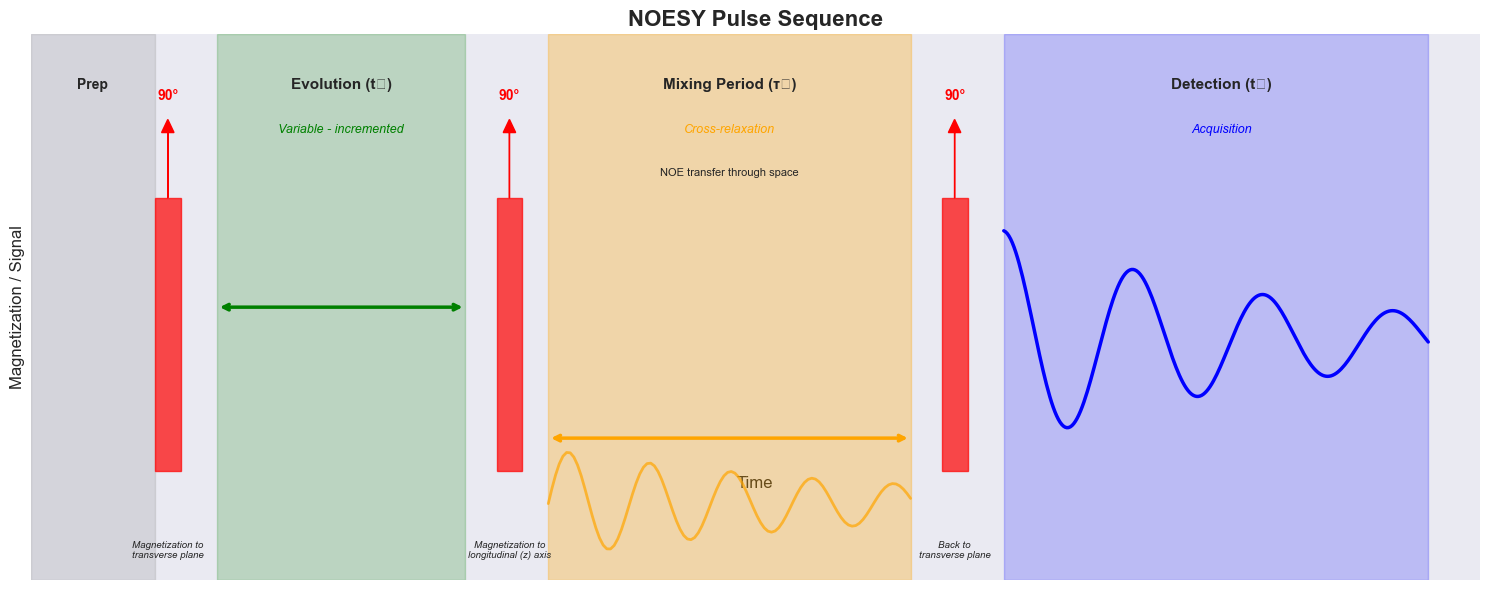

NOESY Pulse Sequence Summary:
1. First 90° pulse → transverse magnetization
2. Evolution period (t₁) → chemical shift labeling
3. Second 90° pulse → convert to z-magnetization
4. Mixing period (τₘ) → NOE cross-relaxation between
                         spatially close nuclei
5. Third 90° pulse → convert to observable magnetization
6. Detection (t₂) → signal acquisition

⚠ Key: During mixing, through-SPACE interactions dominate!
       This reveals stereochemical relationships.


In [41]:
# NOESY Pulse Sequence Visualization (updated for general chemistry)

fig, ax = plt.subplots(figsize=(15, 6))

ax.set_xlim(0, 14)
ax.set_ylim(-1, 4)
ax.set_title('NOESY Pulse Sequence', fontsize=16, fontweight='bold')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Magnetization / Signal', fontsize=12)

# Preparation
ax.axvspan(0, 1.2, alpha=0.2, color='gray')
ax.text(0.6, 3.5, 'Prep', ha='center', fontsize=10, fontweight='bold')

# First 90° Pulse
ax.add_patch(plt.Rectangle((1.2, 0), 0.25, 2.5, color='red', alpha=0.7))
ax.arrow(1.325, 2.5, 0, 0.6, head_width=0.12, head_length=0.12, fc='red', ec='red')
ax.text(1.325, 3.4, '90°', ha='center', fontsize=10, fontweight='bold', color='red')

# Evolution period (t1)
ax.axvspan(1.8, 4.2, alpha=0.2, color='green')
ax.annotate('', xy=(4.2, 1.5), xytext=(1.8, 1.5),
            arrowprops=dict(arrowstyle='<->', color='green', lw=2.5))
ax.text(3.0, 3.5, 'Evolution (t₁)', ha='center', fontsize=11, fontweight='bold')
ax.text(3.0, 3.1, 'Variable - incremented', ha='center', fontsize=9, style='italic', color='green')

# Second 90° Pulse
ax.add_patch(plt.Rectangle((4.5, 0), 0.25, 2.5, color='red', alpha=0.7))
ax.arrow(4.625, 2.5, 0, 0.6, head_width=0.12, head_length=0.12, fc='red', ec='red')
ax.text(4.625, 3.4, '90°', ha='center', fontsize=10, fontweight='bold', color='red')

# Mixing period (tau_m)
ax.axvspan(5.0, 8.5, alpha=0.3, color='orange')
ax.annotate('', xy=(8.5, 0.3), xytext=(5.0, 0.3),
            arrowprops=dict(arrowstyle='<->', color='orange', lw=2.5))
ax.text(6.75, 3.5, 'Mixing Period (τₘ)', ha='center', fontsize=11, fontweight='bold')
ax.text(6.75, 3.1, 'Cross-relaxation', ha='center', fontsize=9, style='italic', color='orange')
ax.text(6.75, 2.7, 'NOE transfer through space', ha='center', fontsize=8)

# Add wavy lines to show relaxation
t_mix = np.linspace(5.0, 8.5, 100)
relax_signal = 0.5 * np.exp(-0.3 * (t_mix - 5.0)) * np.sin(8 * (t_mix - 5.0))
ax.plot(t_mix, -0.3 + relax_signal, 'orange', linewidth=2, alpha=0.7)

# Third 90° Pulse
ax.add_patch(plt.Rectangle((8.8, 0), 0.25, 2.5, color='red', alpha=0.7))
ax.arrow(8.925, 2.5, 0, 0.6, head_width=0.12, head_length=0.12, fc='red', ec='red')
ax.text(8.925, 3.4, '90°', ha='center', fontsize=10, fontweight='bold', color='red')

# Detection period
ax.axvspan(9.4, 13.5, alpha=0.2, color='blue')
t_acq = np.linspace(9.4, 13.5, 250)
fid = np.exp(-0.35 * (t_acq - 9.4)) * np.cos(5 * (t_acq - 9.4))
ax.plot(t_acq, 1.2 + fid, 'b-', linewidth=2.5)
ax.text(11.5, 3.5, 'Detection (t₂)', ha='center', fontsize=11, fontweight='bold')
ax.text(11.5, 3.1, 'Acquisition', ha='center', fontsize=9, style='italic', color='blue')

# Annotations
ax.annotate('Magnetization to\ntransverse plane', xy=(1.325, -0.5), xytext=(1.325, -0.8),
            ha='center', fontsize=7, style='italic')
ax.annotate('Magnetization to\nlongitudinal (z) axis', xy=(4.625, -0.5), xytext=(4.625, -0.8),
            ha='center', fontsize=7, style='italic')
ax.annotate('Back to\ntransverse plane', xy=(8.925, -0.5), xytext=(8.925, -0.8),
            ha='center', fontsize=7, style='italic')

ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))

plt.tight_layout()
plt.show()

print("NOESY Pulse Sequence Summary:")
print("=" * 60)
print("1. First 90° pulse → transverse magnetization")
print("2. Evolution period (t₁) → chemical shift labeling")
print("3. Second 90° pulse → convert to z-magnetization")
print("4. Mixing period (τₘ) → NOE cross-relaxation between")
print("                         spatially close nuclei")
print("5. Third 90° pulse → convert to observable magnetization")
print("6. Detection (t₂) → signal acquisition")
print("\n⚠ Key: During mixing, through-SPACE interactions dominate!")
print("       This reveals stereochemical relationships.")

C:\Users\Windows User\AppData\Local\Temp\ipykernel_10644\3333256260.py:167: UserWarning: Glyph 8323 (\N{SUBSCRIPT THREE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Windows User\AppData\Local\Temp\ipykernel_10644\3333256260.py:167: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Windows User\AppData\Local\Temp\ipykernel_10644\3333256260.py:167: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Windows User\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Windows User\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Windows User\AppData\Roaming\Python\Pyth

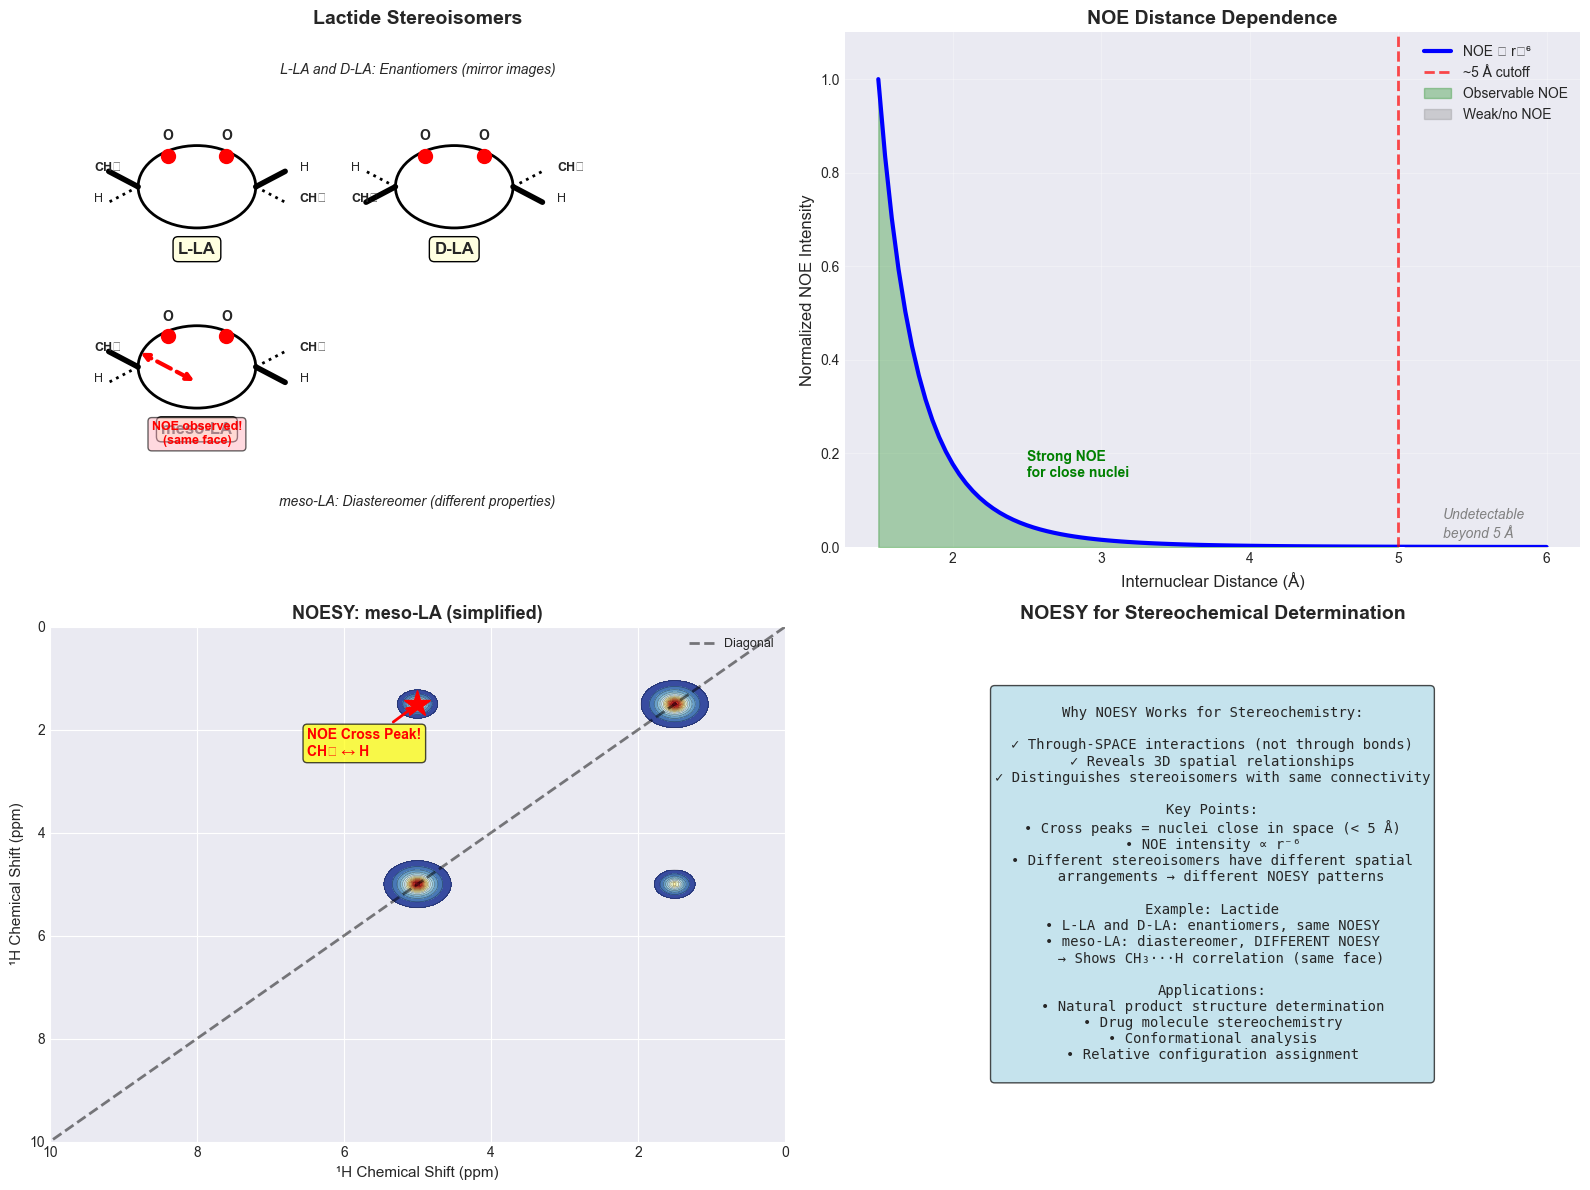

NOESY for Stereochemical Determination:
Lactide Example:
  • L-LA: CH₃ and H on OPPOSITE faces → NO NOE
  • D-LA: CH₃ and H on OPPOSITE faces → NO NOE
  • meso-LA: CH₃ and H on SAME face → STRONG NOE ✓

Key Concept:
  COSY/HMBC: Same for all three isomers (same connectivity)
  NOESY: Different for meso-LA (different spatial arrangement)

💡 This is why NOESY is essential for stereochemistry!


In [42]:
# Visualize stereochemical determination using NOESY: Lactide example

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top left: Lactide structures
ax1 = axes[0, 0]
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)
ax1.axis('off')
ax1.set_title('Lactide Stereoisomers', fontsize=14, fontweight='bold')

# Draw simplified ring structures
structures = [
    {'name': 'L-LA', 'x': 2, 'y': 7, 'me_up': [True, False], 'h_up': [False, True]},
    {'name': 'D-LA', 'x': 5.5, 'y': 7, 'me_up': [False, True], 'h_up': [True, False]},
    {'name': 'meso-LA', 'x': 2, 'y': 3.5, 'me_up': [True, False], 'h_up': [True, False]},
]

for struct in structures:
    x, y = struct['x'], struct['y']
    
    # Draw ring (simplified hexagon)
    ring = plt.Circle((x, y), 0.8, fill=False, edgecolor='black', linewidth=2)
    ax1.add_patch(ring)
    
    # O atoms in ring
    ax1.plot([x - 0.4, x + 0.4], [y + 0.6, y + 0.6], 'ro', markersize=10)
    ax1.text(x - 0.4, y + 0.9, 'O', fontsize=10, ha='center', fontweight='bold')
    ax1.text(x + 0.4, y + 0.9, 'O', fontsize=10, ha='center', fontweight='bold')
    
    # Left side - CH3 and H
    if struct['me_up'][0]:  # Me up (wedge)
        ax1.plot([x - 0.8, x - 1.2], [y, y + 0.3], 'k-', linewidth=4)
        ax1.text(x - 1.4, y + 0.3, 'CH₃', fontsize=9, fontweight='bold')
        ax1.plot([x - 0.8, x - 1.2], [y, y - 0.3], 'k:', linewidth=2)
        ax1.text(x - 1.4, y - 0.3, 'H', fontsize=9)
    else:  # Me down (dash)
        ax1.plot([x - 0.8, x - 1.2], [y, y - 0.3], 'k-', linewidth=4)
        ax1.text(x - 1.4, y - 0.3, 'CH₃', fontsize=9, fontweight='bold')
        ax1.plot([x - 0.8, x - 1.2], [y, y + 0.3], 'k:', linewidth=2)
        ax1.text(x - 1.4, y + 0.3, 'H', fontsize=9)
    
    # Right side - H and CH3
    if struct['h_up'][1]:  # H up (wedge)
        ax1.plot([x + 0.8, x + 1.2], [y, y + 0.3], 'k-', linewidth=4)
        ax1.text(x + 1.4, y + 0.3, 'H', fontsize=9)
        ax1.plot([x + 0.8, x + 1.2], [y, y - 0.3], 'k:', linewidth=2)
        ax1.text(x + 1.4, y - 0.3, 'CH₃', fontsize=9, fontweight='bold')
    else:  # H down (dash)
        ax1.plot([x + 0.8, x + 1.2], [y, y - 0.3], 'k-', linewidth=4)
        ax1.text(x + 1.4, y - 0.3, 'H', fontsize=9)
        ax1.plot([x + 0.8, x + 1.2], [y, y + 0.3], 'k:', linewidth=2)
        ax1.text(x + 1.4, y + 0.3, 'CH₃', fontsize=9, fontweight='bold')
    
    # Label
    ax1.text(x, y - 1.3, struct['name'], fontsize=12, ha='center', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightyellow'))
    
    # NOE indication for meso
    if struct['name'] == 'meso-LA':
        ax1.annotate('', xy=(1.2, 3.5 + 0.3), xytext=(-1.2 + x + 1.2, 3.5 - 0.3),
                    arrowprops=dict(arrowstyle='<->', color='red', lw=3, linestyle='--'))
        ax1.text(2, 2.0, 'NOE observed!\n(same face)', ha='center', fontsize=9,
                color='red', fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='pink', alpha=0.6))

ax1.text(5, 9.2, 'L-LA and D-LA: Enantiomers (mirror images)', fontsize=10, ha='center', style='italic')
ax1.text(5, 0.8, 'meso-LA: Diastereomer (different properties)', fontsize=10, ha='center', style='italic')

# Top right: NOE distance dependence
ax2 = axes[0, 1]
distances = np.linspace(1.5, 6, 100)
noe_intensity = 1 / (distances ** 6)
noe_normalized = noe_intensity / np.max(noe_intensity)

ax2.plot(distances, noe_normalized, 'b-', linewidth=3, label='NOE ∝ r⁻⁶')
ax2.axvline(x=5, color='red', linestyle='--', linewidth=2, alpha=0.7, label='~5 Å cutoff')
ax2.fill_between(distances, 0, noe_normalized, where=(distances <= 5), alpha=0.3, color='green', label='Observable NOE')
ax2.fill_between(distances, 0, noe_normalized, where=(distances > 5), alpha=0.3, color='gray', label='Weak/no NOE')

ax2.set_xlabel('Internuclear Distance (Å)', fontsize=12)
ax2.set_ylabel('Normalized NOE Intensity', fontsize=12)
ax2.set_title('NOE Distance Dependence', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)
ax2.set_ylim(0, 1.1)

# Add annotations
ax2.annotate('Strong NOE\nfor close nuclei', xy=(2.5, 0.15), fontsize=10, color='green', fontweight='bold')
ax2.annotate('Undetectable\nbeyond 5 Å', xy=(5.3, 0.02), fontsize=10, color='gray', style='italic')

# Bottom left: Simulated NOESY for meso-LA
ax3 = axes[1, 0]
# Create simplified NOESY spectrum
f1 = np.linspace(0, 10, 200)
f2 = np.linspace(0, 10, 200)
F1, F2 = np.meshgrid(f1, f2)

spectrum = np.zeros_like(F1)

# Add diagonal peaks (CH3 at ~1.5 ppm, H at ~5.0 ppm)
ch3_shift = 1.5
h_shift = 5.0

spectrum += lorentzian_2d(F1, F2, ch3_shift, ch3_shift, 0.15)
spectrum += lorentzian_2d(F1, F2, h_shift, h_shift, 0.15)

# Add cross peaks for meso-LA (NOE between CH3 and H)
spectrum += 0.6 * lorentzian_2d(F1, F2, ch3_shift, h_shift, 0.12)
spectrum += 0.6 * lorentzian_2d(F1, F2, h_shift, ch3_shift, 0.12)

levels = np.linspace(0.1, np.max(spectrum), 15)
contour = ax3.contourf(F2, F1, spectrum, levels=levels, cmap='RdYlBu_r')
ax3.contour(F2, F1, spectrum, levels=levels, colors='black', linewidths=0.5, alpha=0.4)
ax3.plot([0, 10], [0, 10], 'k--', linewidth=2, alpha=0.5, label='Diagonal')

# Annotate cross peak
ax3.plot(h_shift, ch3_shift, 'r*', markersize=20)
ax3.annotate('NOE Cross Peak!\nCH₃ ↔ H', xy=(h_shift, ch3_shift), xytext=(6.5, 2.5),
            fontsize=10, color='red', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

ax3.set_xlabel('¹H Chemical Shift (ppm)', fontsize=11)
ax3.set_ylabel('¹H Chemical Shift (ppm)', fontsize=11)
ax3.set_title('NOESY: meso-LA (simplified)', fontsize=13, fontweight='bold')
ax3.invert_xaxis()
ax3.invert_yaxis()
ax3.legend(loc='upper right', fontsize=9)

# Bottom right: Summary comparison
ax4 = axes[1, 1]
ax4.set_xlim(0, 10)
ax4.set_ylim(0, 10)
ax4.axis('off')
ax4.set_title('NOESY for Stereochemical Determination', fontsize=14, fontweight='bold')

summary_text = """
Why NOESY Works for Stereochemistry:

✓ Through-SPACE interactions (not through bonds)
✓ Reveals 3D spatial relationships
✓ Distinguishes stereoisomers with same connectivity

Key Points:
• Cross peaks = nuclei close in space (< 5 Å)
• NOE intensity ∝ r⁻⁶
• Different stereoisomers have different spatial
  arrangements → different NOESY patterns

Example: Lactide
• L-LA and D-LA: enantiomers, same NOESY
• meso-LA: diastereomer, DIFFERENT NOESY
  → Shows CH₃···H correlation (same face)

Applications:
• Natural product structure determination
• Drug molecule stereochemistry
• Conformational analysis
• Relative configuration assignment
"""

ax4.text(5, 5, summary_text, fontsize=10, ha='center', va='center',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7),
        family='monospace')

plt.tight_layout()
plt.show()

print("NOESY for Stereochemical Determination:")
print("=" * 70)
print("Lactide Example:")
print("  • L-LA: CH₃ and H on OPPOSITE faces → NO NOE")
print("  • D-LA: CH₃ and H on OPPOSITE faces → NO NOE")
print("  • meso-LA: CH₃ and H on SAME face → STRONG NOE ✓")
print("\nKey Concept:")
print("  COSY/HMBC: Same for all three isomers (same connectivity)")
print("  NOESY: Different for meso-LA (different spatial arrangement)")
print("\n💡 This is why NOESY is essential for stereochemistry!")

C:\Users\Windows User\AppData\Local\Temp\ipykernel_10644\3713365773.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


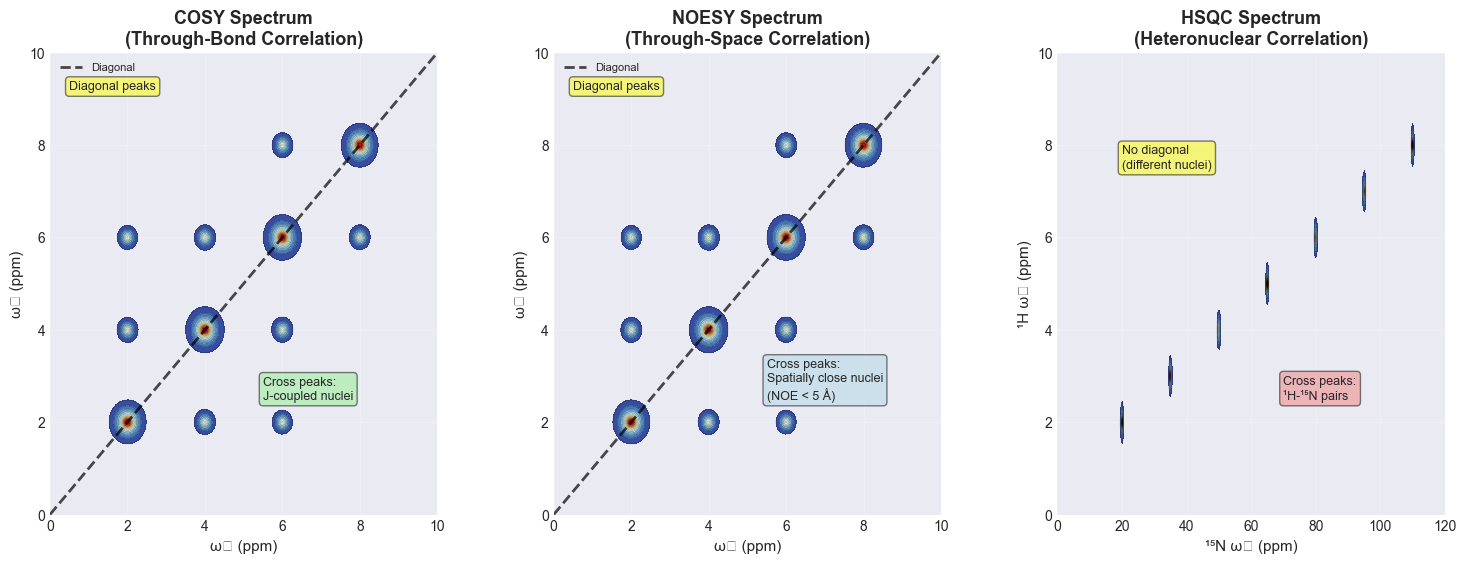

2D Spectrum Comparison:

📊 COSY (Homonuclear):
   • Diagonal peaks: Yes (nuclei with themselves)
   • Cross peaks: J-coupled nuclei (2-3 bonds)
   • Symmetry: Symmetric about diagonal

📊 NOESY (Homonuclear):
   • Diagonal peaks: Yes
   • Cross peaks: Spatially close nuclei (< 5 Å)
   • Symmetry: Symmetric about diagonal

📊 HSQC (Heteronuclear):
   • Diagonal peaks: No (different nuclei on each axis)
   • Cross peaks: ¹H directly bonded to ¹⁵N/¹³C
   • Symmetry: Not applicable

💡 Key: Cross peaks provide the structural information!


In [43]:
# Comprehensive 2D spectrum visualization comparing different techniques

fig = plt.figure(figsize=(18, 6))

# Create three subplots for COSY, NOESY, and HSQC comparison
gs = fig.add_gridspec(1, 3, hspace=0.3, wspace=0.3)

# Function to create annotated 2D spectrum
def create_2d_spectrum(ax, title, diagonal=True, hetero=False):
    """Create a simulated 2D NMR spectrum"""
    # Frequency grids
    f1 = np.linspace(0, 10, 300)
    f2 = np.linspace(0, 10, 300) if not hetero else np.linspace(0, 120, 300)
    F1, F2 = np.meshgrid(f1, f2)
    
    spectrum = np.zeros_like(F1)
    
    if not hetero:  # Homonuclear
        # Add diagonal peaks
        if diagonal:
            for freq in [2, 4, 6, 8]:
                spectrum += lorentzian_2d(F1, F2, freq, freq, 0.15)
        
        # Add cross peaks (symmetric)
        cross_pairs = [(2, 4), (4, 6), (2, 6), (6, 8)]
        for f1_pos, f2_pos in cross_pairs:
            spectrum += 0.5 * lorentzian_2d(F1, F2, f1_pos, f2_pos, 0.12)
            spectrum += 0.5 * lorentzian_2d(F1, F2, f2_pos, f1_pos, 0.12)
    
    else:  # Heteronuclear (HSQC)
        # No diagonal peaks, different frequency ranges
        hsqc_pairs = [(2, 20), (3, 35), (4, 50), (5, 65), (6, 80), (7, 95), (8, 110)]
        for f1_pos, f2_pos in hsqc_pairs:
            spectrum += lorentzian_2d(F1, F2, f1_pos, f2_pos, 0.15)
    
    # Plot
    levels = np.linspace(np.max(spectrum) * 0.1, np.max(spectrum), 15)
    contour = ax.contourf(F2, F1, spectrum, levels=levels, cmap='RdYlBu_r')
    ax.contour(F2, F1, spectrum, levels=levels, colors='black', linewidths=0.5, alpha=0.3)
    
    if diagonal and not hetero:
        ax.plot([0, 10], [0, 10], 'k--', linewidth=2, alpha=0.7, label='Diagonal')
        ax.legend(loc='upper left', fontsize=8)
    
    ax.set_xlabel('ω₂ (ppm)' if not hetero else '¹⁵N ω₂ (ppm)', fontsize=11)
    ax.set_ylabel('ω₁ (ppm)' if not hetero else '¹H ω₁ (ppm)', fontsize=11)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.2)
    
    return spectrum

# Subplot 1: COSY
ax1 = fig.add_subplot(gs[0, 0])
create_2d_spectrum(ax1, 'COSY Spectrum\n(Through-Bond Correlation)', diagonal=True, hetero=False)
ax1.text(0.5, 9.2, 'Diagonal peaks', fontsize=9, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
ax1.text(5.5, 2.5, 'Cross peaks:\nJ-coupled nuclei', fontsize=9, 
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

# Subplot 2: NOESY
ax2 = fig.add_subplot(gs[0, 1])
create_2d_spectrum(ax2, 'NOESY Spectrum\n(Through-Space Correlation)', diagonal=True, hetero=False)
ax2.text(0.5, 9.2, 'Diagonal peaks', fontsize=9, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
ax2.text(5.5, 2.5, 'Cross peaks:\nSpatially close nuclei\n(NOE < 5 Å)', fontsize=9, 
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

# Subplot 3: HSQC
ax3 = fig.add_subplot(gs[0, 2])
create_2d_spectrum(ax3, 'HSQC Spectrum\n(Heteronuclear Correlation)', diagonal=False, hetero=True)
ax3.text(20, 7.5, 'No diagonal\n(different nuclei)', fontsize=9, 
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
ax3.text(70, 2.5, 'Cross peaks:\n¹H-¹⁵N pairs', fontsize=9, 
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

plt.tight_layout()
plt.show()

print("2D Spectrum Comparison:")
print("=" * 70)
print("\n📊 COSY (Homonuclear):")
print("   • Diagonal peaks: Yes (nuclei with themselves)")
print("   • Cross peaks: J-coupled nuclei (2-3 bonds)")
print("   • Symmetry: Symmetric about diagonal")
print("\n📊 NOESY (Homonuclear):")
print("   • Diagonal peaks: Yes")
print("   • Cross peaks: Spatially close nuclei (< 5 Å)")
print("   • Symmetry: Symmetric about diagonal")
print("\n📊 HSQC (Heteronuclear):")
print("   • Diagonal peaks: No (different nuclei on each axis)")
print("   • Cross peaks: ¹H directly bonded to ¹⁵N/¹³C")
print("   • Symmetry: Not applicable")
print("\n💡 Key: Cross peaks provide the structural information!")

## Applications in Protein NMR

### Why Protein NMR?

Proteins are essential macromolecules, and understanding their 3D structure is crucial for:
- Understanding biological function
- Drug design and discovery
- Studying protein-ligand interactions
- Investigating protein dynamics and folding
- Characterizing protein-protein interactions

**Challenges for 1D NMR:**
- Large molecular weight (thousands of atoms)
- Hundreds of amino acids
- Severe signal overlap
- Complex spin systems

**Solution:** Multi-dimensional heteronuclear NMR using isotopically labeled proteins (¹⁵N, ¹³C)

### Isotopic Labeling

Proteins are biosynthesized in bacteria grown on media containing:
- **¹⁵NH₄Cl**: Incorporates ¹⁵N (natural abundance ~0.4% → 100%)
- **¹³C-glucose**: Incorporates ¹³C (natural abundance ~1.1% → 100%)
- **²H₂O**: Deuteration for very large proteins

**Benefits:**
- ¹⁵N and ¹³C are NMR-active (I = 1/2)
- Enables heteronuclear correlation experiments
- Reduces spectral complexity
- Allows multidimensional experiments (3D, 4D)

ValueError: 'k=' is not a valid format string (unrecognized character '=')

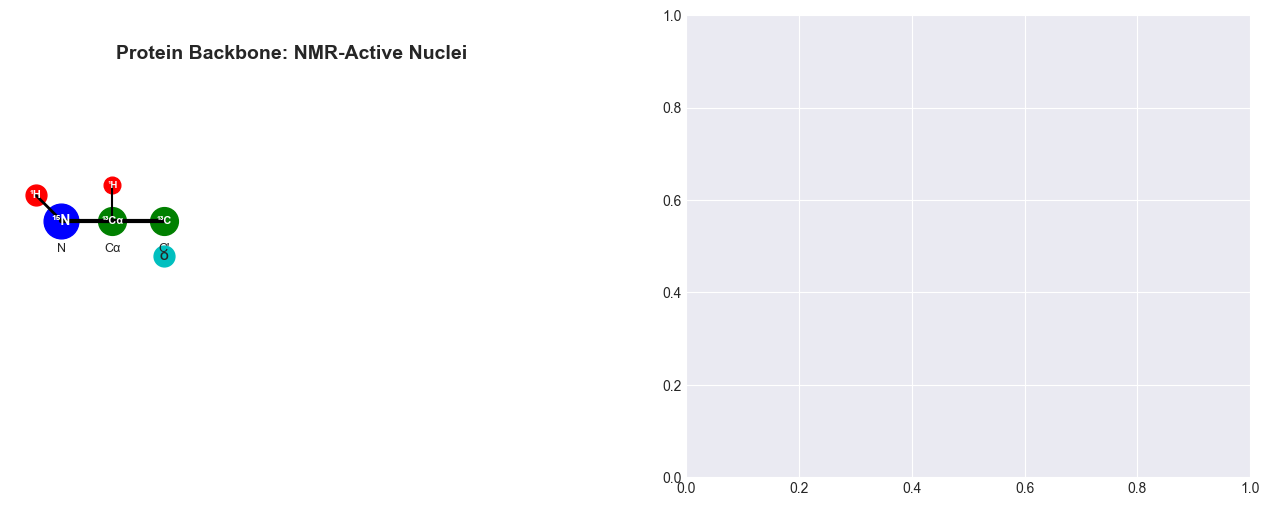

In [44]:
# Visualize protein backbone structure with NMR-active nuclei

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Amino acid backbone structure
ax1 = axes[0]
ax1.set_xlim(-1, 10)
ax1.set_ylim(-1, 6)
ax1.set_aspect('equal')
ax1.axis('off')
ax1.set_title('Protein Backbone: NMR-Active Nuclei', fontsize=14, fontweight='bold')

# Draw three residues
residue_positions = [0, 3.5, 7]
residue_labels = ['Residue i', 'Residue i+1', 'Residue i+2']

for idx, (x_start, label) in enumerate(zip(residue_positions, residue_labels)):
    y_base = 3
    
    # N atom
    ax1.plot(x_start, y_base, 'bo', markersize=25)
    ax1.text(x_start, y_base, '¹⁵N', ha='center', va='center', fontsize=10, color='white', fontweight='bold')
    ax1.text(x_start, y_base - 0.6, 'N', ha='center', fontsize=9)
    
    # H atom on N
    ax1.plot(x_start - 0.5, y_base + 0.5, 'ro', markersize=15)
    ax1.text(x_start - 0.5, y_base + 0.5, '¹H', ha='center', va='center', fontsize=8, color='white', fontweight='bold')
    ax1.plot([x_start, x_start - 0.5], [y_base, y_base + 0.5], 'k-', linewidth=2)
    
    # C_alpha
    ax1.plot(x_start + 1, y_base, 'go', markersize=20)
    ax1.text(x_start + 1, y_base, '¹³Cα', ha='center', va='center', fontsize=8, color='white', fontweight='bold')
    ax1.text(x_start + 1, y_base - 0.6, 'Cα', ha='center', fontsize=9)
    ax1.plot([x_start, x_start + 1], [y_base, y_base], 'k-', linewidth=3)
    
    # H_alpha
    ax1.plot(x_start + 1, y_base + 0.7, 'ro', markersize=12)
    ax1.text(x_start + 1, y_base + 0.7, '¹H', ha='center', va='center', fontsize=7, color='white', fontweight='bold')
    ax1.plot([x_start + 1, x_start + 1], [y_base, y_base + 0.7], 'k-', linewidth=1.5)
    
    # C=O
    ax1.plot(x_start + 2, y_base, 'go', markersize=20)
    ax1.text(x_start + 2, y_base, '¹³C', ha='center', va='center', fontsize=8, color='white', fontweight='bold')
    ax1.text(x_start + 2, y_base - 0.6, "C'", ha='center', fontsize=9)
    ax1.plot([x_start + 1, x_start + 2], [y_base, y_base], 'k-', linewidth=3)
    
    # O
    ax1.plot(x_start + 2, y_base - 0.7, 'co', markersize=15)
    ax1.text(x_start + 2, y_base - 0.7, 'O', ha='center', va='center', fontsize=8, fontweight='bold')
    ax1.plot([x_start + 2, x_start + 2], [y_base, y_base - 0.7], 'k=', linewidth=3)
    
    # Side chain (R group)
    ax1.plot(x_start + 1, y_base - 0.7, marker='s', markersize=15, color='purple', alpha=0.6)
    ax1.text(x_start + 1, y_base - 0.7, 'R', ha='center', va='center', fontsize=9, fontweight='bold')
    ax1.plot([x_start + 1, x_start + 1], [y_base, y_base - 0.7], 'k-', linewidth=1.5)
    
    # Label residue
    ax1.text(x_start + 1, y_base + 1.5, label, ha='center', fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
    
    # Connect to next residue
    if idx < len(residue_positions) - 1:
        ax1.plot([x_start + 2, residue_positions[idx + 1]], [y_base, y_base], 'k-', linewidth=3)

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=12, label='¹⁵N (I=1/2)'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=12, label='¹³C (I=1/2)'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='¹H (I=1/2)'),
]
ax1.legend(handles=legend_elements, loc='upper right', fontsize=10)

# Right: Connectivity pattern
ax2 = axes[1]
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 10)
ax2.axis('off')
ax2.set_title('Key Correlations in Protein NMR', fontsize=14, fontweight='bold')

# List correlations
correlations = [
    ("¹H-¹⁵N HSQC", "One-bond: Backbone NH", "lightblue", 8.5),
    ("¹H-¹³C HSQC", "One-bond: Cα-Hα, side chains", "lightgreen", 7.0),
    ("HNCO", "3D: H-N-C' connectivity", "lightyellow", 5.5),
    ("HNCA", "3D: H-N-Cα connectivity", "lightcoral", 4.0),
    ("NOESY", "Through-space: Distance constraints", "lavender", 2.5),
    ("TOCSY", "Through-bond: Side chain assignment", "peachpuff", 1.0),
]

for exp_name, description, color, y_pos in correlations:
    ax2.add_patch(plt.Rectangle((0.2, y_pos - 0.3), 9.6, 0.8, 
                                facecolor=color, edgecolor='black', linewidth=2))
    ax2.text(0.5, y_pos + 0.1, exp_name, fontsize=11, fontweight='bold', va='center')
    ax2.text(0.5, y_pos - 0.1, description, fontsize=9, style='italic', va='center')

ax2.text(5, 9.5, 'Building Blocks of Protein Structure Determination', 
         ha='center', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print("Protein Backbone Repeating Unit:")
print("=" * 60)
print("    -NH-Cα(R)-C'(=O)- (repeats for each amino acid)")
print("\nNMR-Active Nuclei in Labeled Proteins:")
print("  • ¹H: Natural abundance ~100%, γ = 42.58 MHz/T")
print("  • ¹⁵N: Labeled ~100%, γ = -4.32 MHz/T (low sensitivity)")
print("  • ¹³C: Labeled ~100%, γ = 10.71 MHz/T")
print("\nStrategy: Use ¹H sensitivity to detect ¹⁵N and ¹³C indirectly!")

### Heteronuclear Single Quantum Coherence (HSQC)

#### Overview

**HSQC** is the cornerstone experiment for protein NMR. It correlates ¹H nuclei with directly bonded heteronuclei (typically ¹⁵N or ¹³C).

**Why HSQC is Essential:**
- Each backbone NH group gives one cross peak
- Each amino acid (except proline) has one NH
- Provides a "fingerprint" of the protein
- Well-resolved peaks even for large proteins
- Monitors protein folding, binding, dynamics

#### The Sensitivity Problem

¹⁵N has a low gyromagnetic ratio (γ):
- **¹H**: γ = 42.58 MHz/T (high sensitivity)
- **¹⁵N**: γ = -4.32 MHz/T (~10% of ¹H)
- Direct ¹⁵N detection would give very weak signals

**Solution:** Indirect detection via **polarization transfer**
- Transfer magnetization from sensitive ¹H to ¹⁵N
- Let ¹⁵N evolve (chemical shift labeling)
- Transfer back to ¹H for detection
- Result: ¹H sensitivity with ¹⁵N information!

#### INEPT (Insensitive Nuclei Enhanced by Polarization Transfer)

The INEPT sequence is the key mechanism:

1. **Forward INEPT**: ¹H magnetization → ¹⁵N magnetization
2. **Evolution**: ¹⁵N chemical shift evolution
3. **Reverse INEPT**: ¹⁵N magnetization → ¹H magnetization
4. **Detection**: Observe ¹H signal

This provides a **10-fold sensitivity enhancement** compared to direct ¹⁵N detection!

In [ ]:
# HSQC Pulse Sequence Visualization

fig, ax = plt.subplots(figsize=(16, 7))

ax.set_xlim(0, 18)
ax.set_ylim(0, 6)
ax.set_title('¹H-¹⁵N HSQC Pulse Sequence', fontsize=16, fontweight='bold')
ax.set_xlabel('Time', fontsize=12)

# Create two channels: 1H and 15N
y_1H = 4.5
y_15N = 2.0

# Channel labels
ax.text(-0.5, y_1H, '¹H Channel:', fontsize=12, fontweight='bold', va='center')
ax.text(-0.5, y_15N, '¹⁵N Channel:', fontsize=12, fontweight='bold', va='center')

# Draw horizontal lines for channels
ax.plot([0, 17.5], [y_1H, y_1H], 'k-', linewidth=1, alpha=0.3)
ax.plot([0, 17.5], [y_15N, y_15N], 'k-', linewidth=1, alpha=0.3)

# Preparation period
ax.axvspan(0, 1, alpha=0.15, color='gray', ymin=0, ymax=1)
ax.text(0.5, 5.5, 'Prep', ha='center', fontsize=10)

# === FORWARD INEPT ===
# 1H 90° pulse
ax.add_patch(plt.Rectangle((1.2, y_1H - 0.15), 0.2, 1.0, color='red', alpha=0.8))
ax.text(1.3, y_1H + 1.3, '90°', ha='center', fontsize=9, color='red', fontweight='bold')

# Delay τ = 1/(4J)
ax.axvspan(1.6, 2.8, alpha=0.2, color='cyan', ymin=0, ymax=1)
ax.text(2.2, 5.5, 'τ = 1/(4J_NH)', ha='center', fontsize=9, style='italic')

# Simultaneous 180° pulses (1H and 15N)
ax.add_patch(plt.Rectangle((3.0, y_1H - 0.15), 0.15, 1.0, color='orange', alpha=0.8))
ax.add_patch(plt.Rectangle((3.0, y_15N - 0.15), 0.15, 1.0, color='orange', alpha=0.8))
ax.text(3.075, y_1H + 1.3, '180°', ha='center', fontsize=9, color='orange', fontweight='bold')
ax.text(3.075, y_15N + 1.3, '180°', ha='center', fontsize=9, color='orange', fontweight='bold')
ax.plot([3.075, 3.075], [y_15N + 1.0, y_1H - 0.3], 'k--', linewidth=1, alpha=0.5)

# Second delay τ
ax.axvspan(3.4, 4.6, alpha=0.2, color='cyan', ymin=0, ymax=1)
ax.text(4.0, 5.5, 'τ', ha='center', fontsize=9, style='italic')

# Transfer pulses (1H 90° and 15N 90°)
ax.add_patch(plt.Rectangle((4.8, y_1H - 0.15), 0.2, 1.0, color='red', alpha=0.8))
ax.add_patch(plt.Rectangle((4.8, y_15N - 0.15), 0.2, 1.0, color='blue', alpha=0.8))
ax.text(4.9, y_1H + 1.3, '90°', ha='center', fontsize=9, color='red', fontweight='bold')
ax.text(4.9, y_15N + 1.3, '90°', ha='center', fontsize=9, color='blue', fontweight='bold')
ax.plot([4.9, 4.9], [y_15N + 1.0, y_1H - 0.3], 'k--', linewidth=1, alpha=0.5)

# INEPT label
ax.text(3.0, 0.8, 'FORWARD INEPT', ha='center', fontsize=11, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.6))
ax.annotate('', xy=(5.2, 0.5), xytext=(1.0, 0.5),
            arrowprops=dict(arrowstyle='<->', color='blue', lw=2))

# === EVOLUTION PERIOD ===
ax.axvspan(5.4, 8.0, alpha=0.2, color='green', ymin=0, ymax=1)
ax.annotate('', xy=(8.0, y_15N - 0.6), xytext=(5.4, y_15N - 0.6),
            arrowprops=dict(arrowstyle='<->', color='green', lw=2.5))
ax.text(6.7, 5.5, 'Evolution (t₁)', ha='center', fontsize=11, fontweight='bold')
ax.text(6.7, 5.1, '¹⁵N chemical shift', ha='center', fontsize=9, style='italic', color='green')
ax.text(6.7, 4.7, 'Variable', ha='center', fontsize=9, color='green')

# === REVERSE INEPT ===
# Transfer pulses back
ax.add_patch(plt.Rectangle((8.3, y_1H - 0.15), 0.2, 1.0, color='red', alpha=0.8))
ax.add_patch(plt.Rectangle((8.3, y_15N - 0.15), 0.2, 1.0, color='blue', alpha=0.8))
ax.text(8.4, y_1H + 1.3, '90°', ha='center', fontsize=9, color='red', fontweight='bold')
ax.text(8.4, y_15N + 1.3, '90°', ha='center', fontsize=9, color='blue', fontweight='bold')
ax.plot([8.4, 8.4], [y_15N + 1.0, y_1H - 0.3], 'k--', linewidth=1, alpha=0.5)

# Delay τ
ax.axvspan(8.7, 9.9, alpha=0.2, color='cyan', ymin=0, ymax=1)
ax.text(9.3, 5.5, 'τ', ha='center', fontsize=9, style='italic')

# 180° pulses
ax.add_patch(plt.Rectangle((10.1, y_1H - 0.15), 0.15, 1.0, color='orange', alpha=0.8))
ax.add_patch(plt.Rectangle((10.1, y_15N - 0.15), 0.15, 1.0, color='orange', alpha=0.8))
ax.text(10.175, y_1H + 1.3, '180°', ha='center', fontsize=9, color='orange', fontweight='bold')
ax.text(10.175, y_15N + 1.3, '180°', ha='center', fontsize=9, color='orange', fontweight='bold')
ax.plot([10.175, 10.175], [y_15N + 1.0, y_1H - 0.3], 'k--', linewidth=1, alpha=0.5)

# Delay τ
ax.axvspan(10.5, 11.7, alpha=0.2, color='cyan', ymin=0, ymax=1)
ax.text(11.1, 5.5, 'τ', ha='center', fontsize=9, style='italic')

# INEPT label
ax.text(9.5, 0.8, 'REVERSE INEPT', ha='center', fontsize=11, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.6))
ax.annotate('', xy=(12.0, 0.5), xytext=(8.0, 0.5),
            arrowprops=dict(arrowstyle='<->', color='red', lw=2))

# === DETECTION ===
ax.axvspan(12.2, 17.0, alpha=0.2, color='yellow', ymin=0, ymax=1)
# FID on 1H channel
t_acq = np.linspace(12.2, 17.0, 200)
fid = 0.6 * np.exp(-0.3 * (t_acq - 12.2)) * np.cos(4 * (t_acq - 12.2))
ax.plot(t_acq, y_1H + fid, 'b-', linewidth=2.5)

# 15N decoupling (shown as bar)
ax.add_patch(plt.Rectangle((12.2, y_15N - 0.05), 4.8, 0.4, color='purple', alpha=0.5))
ax.text(14.6, y_15N + 0.8, 'Decoupling', ha='center', fontsize=8, style='italic')

ax.text(14.6, 5.5, 'Detection (t₂)', ha='center', fontsize=11, fontweight='bold')
ax.text(14.6, 5.1, '¹H acquisition with ¹⁵N decoupling', ha='center', fontsize=9, style='italic')

ax.set_yticks([])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()

print("HSQC Pulse Sequence Breakdown:")
print("=" * 70)
print("1. FORWARD INEPT: Transfer ¹H polarization → ¹⁵N")
print("   - 90° ¹H pulse")
print("   - Delays allow J-coupling evolution")
print("   - Simultaneous 90° pulses complete transfer")
print("\n2. EVOLUTION (t₁): ¹⁵N chemical shift evolution (incremented)")
print("\n3. REVERSE INEPT: Transfer ¹⁵N polarization → ¹H")
print("   - Mirror of forward INEPT")
print("\n4. DETECTION (t₂): Acquire ¹H signal with ¹⁵N decoupling")
print("\n✨ Result: Each NH group gives one cross peak!")
print("   F(¹H chemical shift, ¹⁵N chemical shift)")

In [ ]:
# Simulate a realistic HSQC spectrum (like ubiquitin)

def generate_hsqc_spectrum(num_residues=76, noise_level=0.02):
    """
    Generate a simulated HSQC spectrum for a protein
    
    Parameters:
    -----------
    num_residues : int
        Number of amino acids in protein (ubiquitin has 76)
    noise_level : float
        Background noise level
    """
    # Frequency grids (typical ranges for HSQC)
    # 1H: 6-10 ppm, 15N: 105-135 ppm
    h_freq = np.linspace(6, 10, 500)
    n_freq = np.linspace(105, 135, 500)
    H, N = np.meshgrid(h_freq, n_freq)
    
    spectrum = np.random.randn(*H.shape) * noise_level
    
    # Generate random but realistic NH peak positions
    np.random.seed(42)  # For reproducibility
    
    # Most peaks in well-dispersed region
    h_positions = np.random.normal(8.2, 0.6, num_residues - 10)
    n_positions = np.random.normal(120, 7, num_residues - 10)
    
    # Some peaks in crowded region (glycine tends to be around 8.5-8.8 ppm 1H, 108-112 ppm 15N)
    h_positions_gly = np.random.normal(8.6, 0.15, 10)
    n_positions_gly = np.random.normal(110, 2, 10)
    
    h_positions = np.concatenate([h_positions, h_positions_gly])
    n_positions = np.concatenate([n_positions, n_positions_gly])
    
    # Keep within bounds
    h_positions = np.clip(h_positions, 6.2, 9.8)
    n_positions = np.clip(n_positions, 106, 134)
    
    # Add peaks
    for h_pos, n_pos in zip(h_positions, n_positions):
        # Each peak is a 2D Gaussian
        intensity = np.random.uniform(0.7, 1.0)
        h_width = np.random.uniform(0.03, 0.05)
        n_width = np.random.uniform(0.4, 0.6)
        
        peak = intensity * np.exp(-((H - h_pos)**2 / (2 * h_width**2) + 
                                    (N - n_pos)**2 / (2 * n_width**2)))
        spectrum += peak
    
    return H, N, spectrum, h_positions, n_positions

# Generate HSQC spectrum
H, N, hsqc_spectrum, h_pos, n_pos = generate_hsqc_spectrum(76)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(17, 7))

# Left: Standard contour plot
ax1 = axes[0]
levels = np.linspace(0.15, np.max(hsqc_spectrum), 25)
contour1 = ax1.contour(H, N, hsqc_spectrum, levels=levels, cmap='jet', linewidths=1.2)
ax1.set_xlabel('¹H Chemical Shift (ppm)', fontsize=12)
ax1.set_ylabel('¹⁵N Chemical Shift (ppm)', fontsize=12)
ax1.set_title('¹H-¹⁵N HSQC Spectrum (Simulated Protein)', fontsize=13, fontweight='bold')
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, linestyle='--')

# Annotate some peaks
for i in range(0, min(5, len(h_pos))):
    ax1.annotate(f'Residue {i+1}', 
                xy=(h_pos[i], n_pos[i]), 
                xytext=(h_pos[i] - 0.3, n_pos[i] + 2),
                fontsize=8, color='red',
                arrowprops=dict(arrowstyle='->', color='red', lw=1))

# Mark crowded region
from matplotlib.patches import Rectangle
crowded_region = Rectangle((8.4, 107), 0.5, 6, 
                           fill=False, edgecolor='orange', linewidth=2, linestyle='--')
ax1.add_patch(crowded_region)
ax1.text(8.65, 104, 'Crowded\nregion', ha='center', fontsize=9, color='orange',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# Right: Enhanced view with annotations
ax2 = axes[1]
contourf = ax2.contourf(H, N, hsqc_spectrum, levels=30, cmap='RdYlBu_r')
ax2.contour(H, N, hsqc_spectrum, levels=levels, colors='black', linewidths=0.5, alpha=0.4)
ax2.set_xlabel('¹H Chemical Shift (ppm)', fontsize=12)
ax2.set_ylabel('¹⁵N Chemical Shift (ppm)', fontsize=12)
ax2.set_title('HSQC Spectrum - Intensity Map', fontsize=13, fontweight='bold')
ax2.invert_xaxis()
ax2.invert_yaxis()
cbar = plt.colorbar(contourf, ax=ax2, label='Intensity')

# Add informative text
info_text = f"""
Protein: Simulated (76 residues)
Total peaks: {len(h_pos)}
Expected: 76 - 5 (Pro) = 71

Each peak = one NH group
(one backbone amide per residue)
"""
ax2.text(0.98, 0.02, info_text, transform=ax2.transAxes,
        fontsize=9, verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print("HSQC Spectrum Interpretation:")
print("=" * 70)
print(f"• Total cross peaks observed: {len(h_pos)}")
print("• Each peak represents: One backbone NH group")
print("• Missing peaks: Prolines (no NH), overlapped signals, exchanged amides")
print("\nSpectral Characteristics:")
print("  - Well-dispersed peaks: Good resolution, protein is folded")
print("  - ¹H range: 6-10 ppm (amide protons)")
print("  - ¹⁵N range: 105-135 ppm (amide nitrogens)")
print("  - Glycines: Often ~108-112 ppm ¹⁵N (less shielded)")
print("\nNext Steps in Protein NMR:")
print("  1. ¹H-¹⁵N HSQC → Protein 'fingerprint'")
print("  2. 3D experiments (HNCO, HNCA) → Backbone assignment")
print("  3. NOESY → Distance constraints")
print("  4. Structure calculation → 3D protein structure!")

In [ ]:
# Visualize the NMR structure determination workflow

fig, ax = plt.subplots(figsize=(14, 10))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')
ax.set_title('Protein Structure Determination by NMR: Complete Workflow', 
             fontsize=16, fontweight='bold', pad=20)

# Define workflow steps
steps = [
    {
        'y': 10.5,
        'title': 'Step 1: Sample Preparation',
        'content': 'Express ¹⁵N/¹³C-labeled protein\nPurify and prepare NMR sample',
        'color': 'lightblue'
    },
    {
        'y': 9.0,
        'title': 'Step 2: ¹H-¹⁵N HSQC',
        'content': 'Protein "fingerprint"\nQuality check & folding assessment',
        'color': 'lightgreen'
    },
    {
        'y': 7.5,
        'title': 'Step 3: 3D Triple Resonance',
        'content': 'HNCO, HNCA, HN(CO)CA, etc.\nBackbone assignment',
        'color': 'lightyellow'
    },
    {
        'y': 6.0,
        'title': 'Step 4: Side Chain Assignment',
        'content': 'HCCH-TOCSY, ¹H-¹³C HSQC\nComplete resonance assignment',
        'color': 'lightcoral'
    },
    {
        'y': 4.5,
        'title': 'Step 5: NOESY Experiments',
        'content': '¹H-¹H NOESY, ¹⁵N-NOESY-HSQC\nExtract distance constraints',
        'color': 'plum'
    },
    {
        'y': 3.0,
        'title': 'Step 6: Data Analysis',
        'content': 'Peak picking, constraint extraction\n~10-20 NOEs per residue',
        'color': 'peachpuff'
    },
    {
        'y': 1.5,
        'title': 'Step 7: Structure Calculation',
        'content': 'Simulated annealing, MD\nEnsemble of 20-40 structures',
        'color': 'lightsteelblue'
    },
    {
        'y': 0.2,
        'title': '✓ 3D Structure',
        'content': 'PDB deposition\nBiological insights!',
        'color': 'lightgoldenrodyellow'
    }
]

# Draw workflow
for i, step in enumerate(steps):
    # Box
    box = plt.Rectangle((1, step['y'] - 0.4), 8, 0.9, 
                        facecolor=step['color'], edgecolor='black', linewidth=2)
    ax.add_patch(box)
    
    # Title
    ax.text(5, step['y'] + 0.25, step['title'], 
           ha='center', va='center', fontsize=11, fontweight='bold')
    
    # Content
    ax.text(5, step['y'] - 0.15, step['content'],
           ha='center', va='center', fontsize=9, style='italic')
    
    # Arrow to next step
    if i < len(steps) - 1:
        ax.annotate('', xy=(5, steps[i+1]['y'] + 0.5), xytext=(5, step['y'] - 0.5),
                   arrowprops=dict(arrowstyle='->', lw=3, color='darkblue'))

# Add time estimates on the side
time_labels = [
    (10.5, '1-2 weeks'),
    (9.0, '1-2 days'),
    (7.5, '2-4 weeks'),
    (6.0, '1-2 weeks'),
    (4.5, '1-2 weeks'),
    (3.0, '1-2 weeks'),
    (1.5, '2-4 weeks'),
    (0.2, 'Complete!')
]

for y_pos, time_label in time_labels:
    ax.text(9.5, y_pos, time_label, ha='left', va='center', 
           fontsize=8, style='italic', color='gray')

# Add annotations
ax.text(0.2, 5.5, 'Data\nAcquisition', ha='center', va='center', 
       fontsize=10, fontweight='bold', rotation=90,
       bbox=dict(boxstyle='round', facecolor='cyan', alpha=0.3))

ax.text(0.2, 2.0, 'Computation', ha='center', va='center',
       fontsize=10, fontweight='bold', rotation=90,
       bbox=dict(boxstyle='round', facecolor='orange', alpha=0.3))

# Add legend
legend_text = """
Key Experiments:
• HSQC: 2D heteronuclear correlation
• 3D Triple Resonance: Sequential connectivity
• NOESY: Distance constraints (< 5 Å)

Total Time: ~2-6 months
"""
ax.text(5, -1.0, legend_text, ha='center', va='top', fontsize=9,
       bbox=dict(boxstyle='round', facecolor='lavender', alpha=0.8))

plt.tight_layout()
plt.show()

print("Protein NMR Structure Determination Timeline:")
print("=" * 70)
print("Total time: ~2-6 months (depending on protein complexity)")
print("\nCritical experiments:")
print("  • ¹H-¹⁵N HSQC: Starting point, quality control")
print("  • Triple resonance: Backbone assignment")
print("  • NOESY: Structural constraints")
print("\nTypical constraints for structure calculation:")
print("  • ~500-1500 NOE distance constraints")
print("  • ~100-300 dihedral angle constraints")
print("  • ~50-100 hydrogen bond constraints")
print("\nFinal output: Ensemble of structures (RMSD < 1-2 Å)")

## Other Applications of 2D NMR

While protein structure determination is a major application, 2D NMR has many other important uses across chemistry and biology.

### 1. Pharmaceutical Characterization

**Drug Development:**
- Structure verification of synthetic compounds
- Impurity identification and quantification
- Stereochemistry determination
- Mixture analysis without separation
- Degradation product identification

**Techniques:**
- COSY, TOCSY for connectivity
- ROESY/NOESY for conformation
- HSQC/HMBC for heteronuclear correlations
- DOSY for diffusion measurements

### 2. Carbohydrate Conformational Analysis

**Temperature-Dependent Studies:**
- Glycosidic linkage conformations
- Ring puckering dynamics
- Hydrogen bonding patterns
- Anomeric configurations (α vs β)

**Applications:**
- Polysaccharide structure elucidation
- Oligosaccharide analysis
- Glycoprotein characterization

### 3. Metabolomics

**Biological Fluid Analysis:**
- Plasma/serum metabolite profiling
- Urine metabolite fingerprinting
- Disease biomarker discovery
- Drug metabolism studies

**Advantages:**
- Non-destructive
- Minimal sample preparation
- Quantitative information
- Simultaneous detection of multiple metabolites

**Common Experiments:**
- ¹H-¹H TOCSY (total correlation spectroscopy)
- ¹H-¹³C HSQC for metabolite identification
- J-resolved spectroscopy

### 4. Natural Product Chemistry

- Structure elucidation of complex molecules
- Stereochemistry assignment
- Configuration of natural products
- Mixture analysis

### 5. Polymer Characterization

- Tacticity determination
- Sequence distribution
- Branching analysis
- Molecular weight estimation (via DOSY)

### 6. Material Science

- Solid-state NMR (2D techniques)
- Surface interactions
- Molecular dynamics in materials
- Pharmaceutical formulations

### 7. Protein-Ligand Interactions

**Drug Screening:**
- SAR by NMR (Structure-Activity Relationships)
- Chemical shift perturbation mapping
- Transferred NOE (trNOE)
- Saturation transfer difference (STD)

**Advantages:**
- Study binding in solution
- No need for protein crystallization
- Weak interactions detectable
- Epitope mapping

### 8. Nucleic Acid Structure

- RNA/DNA secondary structure
- Base pairing patterns
- Unusual structures (G-quadruplexes, i-motifs)
- Protein-DNA/RNA interactions

In [ ]:
# Summary visualization of 2D NMR applications

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.4)

# Central title
fig.suptitle('2D NMR: A Versatile Analytical Tool', fontsize=18, fontweight='bold', y=0.98)

# Define applications with colors and icons
applications = [
    {
        'title': 'Protein Structure',
        'techniques': ['HSQC', 'NOESY', 'TOCSY'],
        'uses': 'Structure determination\nDynamics studies',
        'color': 'lightblue',
        'pos': (0, 0)
    },
    {
        'title': 'Drug Discovery',
        'techniques': ['COSY', 'HMBC', 'ROESY'],
        'uses': 'Structure verification\nBinding studies',
        'color': 'lightcoral',
        'pos': (0, 1)
    },
    {
        'title': 'Metabolomics',
        'techniques': ['TOCSY', 'HSQC', 'J-res'],
        'uses': 'Biomarker discovery\nDisease diagnosis',
        'color': 'lightgreen',
        'pos': (0, 2)
    },
    {
        'title': 'Natural Products',
        'techniques': ['COSY', 'HMBC', 'NOESY'],
        'uses': 'Structure elucidation\nStereochemistry',
        'color': 'lightyellow',
        'pos': (1, 0)
    },
    {
        'title': 'Carbohydrates',
        'techniques': ['COSY', 'TOCSY', 'ROESY'],
        'uses': 'Glycosidic linkages\nConformation',
        'color': 'plum',
        'pos': (1, 1)
    },
    {
        'title': 'Polymers',
        'techniques': ['COSY', 'DOSY', 'HSQC'],
        'uses': 'Tacticity\nSequence analysis',
        'color': 'peachpuff',
        'pos': (1, 2)
    },
    {
        'title': 'Nucleic Acids',
        'techniques': ['NOESY', 'COSY', 'TOCSY'],
        'uses': 'DNA/RNA structure\nBase pairing',
        'color': 'lavender',
        'pos': (2, 0)
    },
    {
        'title': 'Materials Science',
        'techniques': ['Solid-state 2D', 'HETCOR'],
        'uses': 'Surface analysis\nFormulations',
        'color': 'lightsteelblue',
        'pos': (2, 1)
    },
    {
        'title': 'Food Chemistry',
        'techniques': ['COSY', 'TOCSY', 'DOSY'],
        'uses': 'Authenticity\nComposition',
        'color': 'wheat',
        'pos': (2, 2)
    }
]

# Create subplots
for app in applications:
    row, col = app['pos']
    ax = fig.add_subplot(gs[row, col])
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')
    
    # Background box
    box = plt.Rectangle((0.5, 0.5), 9, 9, 
                        facecolor=app['color'], 
                        edgecolor='black', 
                        linewidth=2.5,
                        alpha=0.7)
    ax.add_patch(box)
    
    # Title
    ax.text(5, 8, app['title'], 
           ha='center', va='center', 
           fontsize=13, fontweight='bold')
    
    # Techniques
    techniques_text = '\n'.join(app['techniques'])
    ax.text(5, 5.5, 'Techniques:', 
           ha='center', va='center', 
           fontsize=10, fontweight='bold',
           color='darkblue')
    ax.text(5, 4.0, techniques_text,
           ha='center', va='center',
           fontsize=9, style='italic')
    
    # Applications
    ax.text(5, 2.0, app['uses'],
           ha='center', va='center',
           fontsize=9)

plt.tight_layout()
plt.show()

print("2D NMR Application Summary:")
print("=" * 70)
print("\n🔬 Most Common 2D NMR Techniques:")
print("   • COSY: Through-bond (J-coupling) correlations")
print("   • TOCSY: Total correlation spectroscopy")
print("   • NOESY/ROESY: Through-space (NOE) correlations")
print("   • HSQC: ¹H-¹³C or ¹H-¹⁵N heteronuclear correlations")
print("   • HMBC: Long-range heteronuclear correlations")
print("   • DOSY: Diffusion-ordered spectroscopy")
print("\n📊 Key Advantages:")
print("   ✓ Resolves overlapping signals")
print("   ✓ Provides connectivity information")
print("   ✓ Non-destructive analysis")
print("   ✓ Works in solution (physiological conditions)")
print("   ✓ Quantitative measurements possible")
print("\n🎯 Growing Applications:")
print("   • Precision medicine (metabolomics)")
print("   • Drug discovery and development")
print("   • Food authenticity and safety")
print("   • Environmental monitoring")
print("   • Quality control in pharmaceuticals")

## Summary and Key Takeaways

### Historical Perspective
- **1971**: Jean Jeener proposes 2D NMR concept
- **1975-1980s**: Richard Ernst develops practical implementations
- **1991**: Ernst awarded Nobel Prize in Chemistry
- **Today**: Essential tool across chemistry, biochemistry, and medicine

### Core Principles

#### 1. The Second Dimension
- Traditional 1D NMR: f(t) → F(ω)
- 2D NMR: f(t₁, t₂) → F(ω₁, ω₂) via double Fourier transform
- Evolution time (t₁) is systematically incremented
- Creates correlation map showing relationships between nuclei

#### 2. Types of Correlations

| Experiment | Type | Information | Distance/Bonds |
|------------|------|-------------|----------------|
| **COSY** | Homonuclear | J-coupling (bonds) | 2-3 bonds |
| **TOCSY** | Homonuclear | Extended coupling | Whole spin system |
| **NOESY** | Homonuclear | NOE (space) | < 5 Å |
| **HSQC** | Heteronuclear | Direct coupling | 1 bond |
| **HMBC** | Heteronuclear | Long-range coupling | 2-4 bonds |

#### 3. Peak Interpretation
- **Diagonal peaks**: Self-correlation (homonuclear only)
- **Cross peaks**: Correlation between different nuclei
- **Symmetry**: Homonuclear spectra symmetric about diagonal
- **Intensity**: Related to coupling strength or distance

### Why 2D NMR Matters

#### For Small Molecules:
✓ Resolves overlapping signals  
✓ Establishes molecular connectivity  
✓ Determines stereochemistry  
✓ Identifies functional groups  

#### For Proteins:
✓ Determines 3D structure in solution  
✓ Studies dynamics and conformational changes  
✓ Monitors protein-ligand interactions  
✓ Investigates protein folding  

#### General Advantages:
✓ Non-destructive analysis  
✓ Minimal sample preparation  
✓ Quantitative information  
✓ Physiologically relevant conditions  

### Limitations to Consider

- **Time**: 2D experiments take longer than 1D (hours vs. minutes)
- **Sensitivity**: Requires higher concentrations or longer acquisition
- **Protein size**: Standard 2D limited to proteins < 30-40 kDa
- **Isotopic labeling**: Heteronuclear experiments need ¹³C/¹⁵N
- **Data complexity**: Requires expertise to interpret
- **Cost**: Spectrometer time, labeled reagents

### The Future: Multidimensional NMR

**3D NMR**: Adds third frequency dimension (e.g., HNCO, HNCA)
- Essential for larger proteins
- Better resolution through dispersion
- Sequential connectivity

**4D NMR**: Four frequency dimensions
- Very large proteins (> 25 kDa)
- Deuteration often required
- Ultimate resolution for complex systems

**5D+ NMR**: Emerging techniques
- Specialized applications
- Ultra-high field spectrometers

## References and Further Reading

### Foundational Papers

1. **Jeener, J.** (1971). "Ampere International Summer School, Basko Polje, Yugoslavia."  
   *Original proposal of 2D NMR concept*

2. **Aue, W. P., Bartholdi, E., & Ernst, R. R.** (1976). "Two‐dimensional spectroscopy. Application to nuclear magnetic resonance." *The Journal of Chemical Physics*, 64(5), 2229-2246.  
   *First practical implementation of 2D NMR*

3. **Ernst, R. R., Bodenhausen, G., & Wokaun, A.** (1987). *Principles of Nuclear Magnetic Resonance in One and Two Dimensions.* Oxford University Press.  
   *Comprehensive textbook on multidimensional NMR*

### Protein NMR

4. **Cavanagh, J., Fairbrother, W. J., Palmer III, A. G., Rance, M., & Skelton, N. J.** (2007). *Protein NMR Spectroscopy: Principles and Practice* (2nd ed.). Academic Press.  
   *Definitive textbook for protein NMR*

5. **Wüthrich, K.** (1986). *NMR of Proteins and Nucleic Acids.* Wiley-Interscience.  
   *Classic text by Nobel laureate Kurt Wüthrich*

6. **Kay, L. E.** (2011). "Solution NMR spectroscopy of supra-molecular systems, why bother? A methyl-TROSY view." *Journal of Magnetic Resonance*, 210(2), 159-170.  
   *Advanced techniques for large proteins*

### 2D NMR Techniques

7. **Claridge, T. D. W.** (2016). *High-Resolution NMR Techniques in Organic Chemistry* (3rd ed.). Elsevier.  
   *Excellent coverage of 2D NMR for small molecules*

8. **Keeler, J.** (2010). *Understanding NMR Spectroscopy* (2nd ed.). Wiley.  
   *Clear explanations of NMR theory and practice*

9. **Levitt, M. H.** (2008). *Spin Dynamics: Basics of Nuclear Magnetic Resonance* (2nd ed.). Wiley.  
   *Rigorous theoretical treatment*

### Applications

10. **Emwas, A. H., et al.** (2019). "NMR Spectroscopy for Metabolomics Research." *Metabolites*, 9(7), 123.  
    *Review of metabolomics applications*

11. **Furtig, B., Richter, C., Wohnert, J., & Schwalbe, H.** (2003). "NMR spectroscopy of RNA." *ChemBioChem*, 4(10), 936-962.  
    *RNA structure determination*

12. **Meyer, B., & Peters, T.** (2003). "NMR spectroscopy techniques for screening and identifying ligand binding to protein receptors." *Angewandte Chemie International Edition*, 42(8), 864-890.  
    *Drug discovery applications*

### Online Resources

13. **BMRB (Biological Magnetic Resonance Bank)**  
    https://bmrb.io  
    *Database of NMR data for proteins and nucleic acids*

14. **PDB (Protein Data Bank)**  
    https://www.rcsb.org  
    *Repository of 3D structures including NMR structures*

15. **NMR Wiki**  
    http://www.nmr.wiki  
    *Community resource for NMR spectroscopy*

16. **James Keeler's Lecture Notes**  
    http://www-keeler.ch.cam.ac.uk  
    *Excellent online tutorials on NMR theory*

### Software Tools

17. **NMRPipe**: Processing and analysis of multidimensional NMR data
18. **SPARKY**: Visualization and analysis of NMR spectra
19. **CYANA**: Automated structure calculation from NMR data
20. **XPLOR-NIH**: Structure determination and refinement
21. **CCPNMR**: Comprehensive NMR analysis platform

### Review Articles

22. **Wider, G., & Dreier, L.** (2006). "Measuring protein concentrations by NMR spectroscopy." *Journal of the American Chemical Society*, 128(8), 2571-2576.

23. **Riek, R., Wider, G., Pervushin, K., & Wüthrich, K.** (1999). "Polarization transfer by cross-correlated relaxation in solution NMR with very large molecules." *Proceedings of the National Academy of Sciences*, 96(9), 4918-4923.

24. **Sattler, M., Schleucher, J., & Griesinger, C.** (1999). "Heteronuclear multidimensional NMR experiments for the structure determination of proteins in solution." *Progress in Nuclear Magnetic Resonance Spectroscopy*, 34(2), 93-158.

---

### Recommended Learning Path

**Beginners:**
1. Start with Claridge (small molecules) or Keeler (general theory)
2. Practice interpreting COSY and HSQC spectra
3. Understand Fourier transformation concepts

**Intermediate:**
1. Study protein NMR (Cavanagh et al.)
2. Learn about NOESY and distance constraints
3. Explore specific applications in your field

**Advanced:**
1. Spin dynamics (Levitt)
2. Pulse sequence design
3. Multidimensional techniques (3D, 4D)
4. Specialized techniques (solid-state, in-cell NMR)

---

*This notebook provides a foundation in 2D NMR. For detailed experimental protocols and data processing, consult the references above and consider hands-on training at NMR facilities.*

In [ ]:
# Final summary visualization

fig = plt.figure(figsize=(16, 10))

# Create a comprehensive summary diagram
ax = plt.subplot(111)
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

# Title
ax.text(5, 9.5, '2D NMR: From Theory to Application', 
        fontsize=20, fontweight='bold', ha='center',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='lightblue', edgecolor='black', linewidth=3))

# Left column: Experiments
ax.text(1.5, 8.2, 'Key Experiments', fontsize=14, fontweight='bold', ha='center',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

experiments = [
    ('COSY', 'Through-bond (J)', 7.4),
    ('TOCSY', 'Spin systems', 6.8),
    ('NOESY', 'Through-space (NOE)', 6.2),
    ('HSQC', '¹H-X heteronuclear', 5.6),
    ('HMBC', 'Long-range ¹H-X', 5.0),
]

for name, desc, y in experiments:
    ax.text(0.5, y, f'• {name}:', fontsize=11, fontweight='bold')
    ax.text(1.0, y - 0.15, desc, fontsize=9, style='italic', color='gray')

# Center column: Principles
ax.text(5, 8.2, 'Core Principles', fontsize=14, fontweight='bold', ha='center',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

principles = [
    '✓ Variable evolution time (t₁)',
    '✓ Double Fourier transform',
    '✓ F(ω₁, ω₂) correlation map',
    '✓ Diagonal & cross peaks',
    '✓ Polarization transfer (INEPT)',
]

for i, principle in enumerate(principles):
    ax.text(5, 7.3 - i*0.4, principle, fontsize=10, ha='center')

# Right column: Applications
ax.text(8.5, 8.2, 'Major Applications', fontsize=14, fontweight='bold', ha='center',
        bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

applications = [
    ('Protein Structure', 7.4),
    ('Drug Discovery', 6.8),
    ('Metabolomics', 6.2),
    ('Natural Products', 5.6),
    ('Materials Science', 5.0),
]

for app, y in applications:
    ax.text(8.5, y, f'• {app}', fontsize=10, ha='center')

# Bottom section: Key advantages
ax.add_patch(plt.Rectangle((0.3, 3.5), 9.4, 1.2, 
                           facecolor='lavender', edgecolor='black', linewidth=2))
ax.text(5, 4.4, 'Why 2D NMR?', fontsize=13, fontweight='bold', ha='center')
ax.text(5, 3.9, 'Resolves overlapping signals • Reveals connectivity • Non-destructive • Solution conditions',
        fontsize=10, ha='center', style='italic')

# Bottom: Historical timeline
timeline_y = 2.5
ax.plot([1, 9], [timeline_y, timeline_y], 'k-', linewidth=2)

timeline_events = [
    (1.5, '1971\nJeener\nProposal'),
    (4.0, '1976\nErnst et al.\nFirst 2D'),
    (6.5, '1991\nNobel Prize\nErnst'),
    (8.5, 'Today\nEssential\nTool'),
]

for x, label in timeline_events:
    ax.plot(x, timeline_y, 'ro', markersize=12)
    ax.text(x, timeline_y - 0.6, label, fontsize=8, ha='center', va='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

ax.text(5, 0.8, '2D NMR has revolutionized structural biology and analytical chemistry', 
        fontsize=11, ha='center', style='italic', fontweight='bold')

ax.text(5, 0.3, 'Essential for understanding molecular structure, dynamics, and interactions',
        fontsize=10, ha='center', color='darkblue')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("NOTEBOOK COMPLETE: 2D NMR Spectroscopy")
print("=" * 70)
print("\n✓ Topics Covered:")
print("  • Introduction and historical development")
print("  • Experimental setup and pulse sequences")
print("  • Spin Hamiltonian theory")
print("  • COSY (Correlation Spectroscopy)")
print("  • NOE and NOESY (Nuclear Overhauser Effect)")
print("  • 2D spectrum interpretation")
print("  • HSQC and protein NMR applications")
print("  • Protein structure determination workflow")
print("  • Diverse applications across science")
print("  • References and resources")
print("\n🎓 Learning Outcomes Achieved:")
print("  ✓ Understand principles of 2D NMR")
print("  ✓ Interpret 2D correlation maps")
print("  ✓ Recognize different 2D techniques")
print("  ✓ Appreciate applications in protein science")
print("  ✓ Know the complete NMR structure workflow")
print("\n📚 Next Steps:")
print("  • Practice with real NMR datasets")
print("  • Explore software tools (NMRPipe, SPARKY)")
print("  • Study advanced 3D/4D techniques")
print("  • Apply to your research area")
print("\n" + "=" * 70)